# Description

In [66]:
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from scipy import stats
from scipy.stats import zscore
import numpy as np
import csv
import os
import shutil
import multiprocess
import warnings
import gc
import psutil
warnings.filterwarnings('ignore')

# Parameters

In [61]:
assembly = "./data/cladorhizid_v0.6_hapA/clado_v0.6_hapA.fasta"
coverage_per_contig = "./data/cladorhizid_hifi_assembly.coverage"
coverage_per_base = "./data/cladorhizid_hifi_assembly.depth"
n_cores = 2
out_dir = "out_dir/"
min_contig_size = 1000000
chunk_size = 10000
visualize_gc = True
visualize_coverage = True
visualize_contigs = True
visualize_histogram = True
threshold_pct = 50
visualize_blob = True
plot_min_length = 100000
n_clusters = 2
len_to_blast = 1000
space_to_blast = 10000
threshold = 0.8
genome_size = 430000000

# Create outdirs

In [76]:
cluster_info = out_dir + "cluster_info/"
coverage_output = out_dir + "Coverage_output/"
GC_visual_output = out_dir + "GC_visual_output/"
individual_output = out_dir + "Individual/"
if not os.path.exists(cluster_info):
    os.makedirs(cluster_info)
if not os.path.exists(coverage_output):
    os.makedirs(coverage_output)
if not os.path.exists(GC_visual_output):
    os.makedirs(GC_visual_output)
if not os.path.exists(individual_output):
    os.makedirs(individual_output)

# Naive GC content for each content

In [4]:
def get_gc_content(fasta_file):
    """
    Reads in a FASTA file and returns a dictionary mapping contig IDs to their GC content
    """
    gc_content = {}
    current_id = None
    current_seq = ""
    
    with open(fasta_file, "r") as f:
        for line in f:
            if line.startswith(">"):
                # If this is a new contig, calculate the GC content for the previous one (if there was one)
                if current_id is not None:
                    #remove if current_seq y min_contig_size
                    if len(current_seq) > min_contig_size:
                        gc_content[current_id] = [(current_seq.count("G") + current_seq.count("C")) / len(current_seq), len(current_seq)]
                        
                # Start the new contig
                #current_id = line.strip()[1:].split("/")[3]
                current_id = line.strip().strip('>')
                current_seq = ""
            else:
                current_seq += line.strip()
    
    # Calculate GC content for the final contig
    if len(current_seq) > min_contig_size:
        gc_content[current_id] = [(current_seq.count("G") + current_seq.count("C")) / len(current_seq), len(current_seq)]
    
    return gc_content

In [5]:
naive_gc = get_gc_content(assembly)
print(len(naive_gc))

40


# GC content for each contig by averaging in given chunk sizes

In [6]:
def get_gc_content_chunks(fasta_file, chunk_size):
    """
    Reads in a FASTA file and returns a dictionary mapping contig IDs to a list of gc content per chunk size
    """
    gc_content = {}
    current_id = None
    current_seq = ""
    chunks = []
    
    with open(fasta_file, "r") as f:
        for line in f:
            if line.startswith(">"):
                # If this is a new contig, calculate the GC content for the previous one (if there was one)
                if current_id is not None:
                    #remove if current_seq < min_contig_size
                    if len(current_seq) > min_contig_size:  
                        i = 0
                        while i < len(current_seq):
                            # check for last chunk
                            if (i + chunk_size) > len(current_seq):
                                end = len(current_seq)
                            else:
                                end = i + chunk_size
                            sub = current_seq[i:end]
                            gc = round(((sub.count("G") + sub.count("C")) / len(sub)),2)
                            chunks.append(gc)
                            i = end
                        # add to dictionary in form {current_id : [array of GC content of given chunk size]}
                        gc_content[current_id] = [chunks, len(current_seq)]

                # Start the new contig
                #current_id = line.strip()[1:].split("/")[3]
                current_id = line.strip().strip('>')
                current_seq = ""
                chunks = []
                
            else:
                current_seq += line.strip()
                
        # calculate GC content for the last contig
        if current_id is not None and len(current_seq) > 1:
            i = 0
            while i < len(current_seq):
                # check for last chunk
                if (i + chunk_size) > len(current_seq):
                    end = len(current_seq)
                else:
                    end = i + chunk_size
                sub = current_seq[i:end]
                gc = round(((sub.count("G") + sub.count("C")) / len(sub)), 2)
                chunks.append(gc)
                i = end
            # add to dictionary in form {current_id : [array of GC content of given chunk size, length]}
            gc_content[current_id] = [chunks, len(current_seq)]
        
    return gc_content

In [7]:
chunks = get_gc_content_chunks(assembly, chunk_size)
gc_trimmed_mean = {}
#Get the trimmed mean from chunks
for entry in chunks:
    length = chunks.get(entry)[1]
    avg_cov = chunks.get(entry)[0]
    gc_trimmed_mean[entry] = [stats.trim_mean(avg_cov, 0.05), length]
print('Length check: ', len(gc_trimmed_mean))

Length check:  41


# Visualize GC content 

In [8]:
if visualize_gc:

    save_dir = out_dir + "/GC_visual_output"
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)

    def process_gc_plot(chunk):
        id = chunk
        
        # added to resume if crashes for whatever reason
        save_path = os.path.join(save_dir, "GC_content_" + str(id) + ".png")
        
        # Skip if the plot already exists
        if not os.path.exists(save_path):
            gc_content = np.array(chunks.get(chunk)[0])

            # create a bar plot
            fig, ax = plt.subplots()
            mean_gc = np.mean(gc_content)
            colors = ['red' if abs(gc - mean_gc) / mean_gc * 100 >= threshold_pct else 'blue' for gc in gc_content]
            plt.bar(range(len(gc_content)), gc_content, color=colors, width=1)
            ax.axhline(y=gc_trimmed_mean[id][0], color='black')
            plt.title("Contig: " + str(id))
            plt.xlabel('index of Chunk of size: ' + str(chunk_size))
            plt.ylabel('GC content')
            #save the plot
            plt.savefig(save_path)
            plt.close()
        else:
            print(f'Skipping {id} (already exists)')

    if __name__ == '__main__':
        with multiprocess.Pool(processes=n_cores) as pool:
            print('Starting Visualize GC content')
            pool.map(process_gc_plot, chunks.keys())
            print('Finished Visualize GC content')

else:
    print("GC visualization is turned off.")    

Starting Visualize GC content
Finished Visualize GC content


# Naive coverage

In [9]:
def get_coverage_per_contig(coverage_file):
    naive_coverage = {}

    with open(coverage_file, "r") as f:
        next(f)
        for line in f:
            # Split line into columns
            columns = line.strip().split("\t")
            #print(columns)

            #only add if length > min_contig_size
            if (int(columns[2]) - int(columns[1])) > min_contig_size:
                # Use the first column as key and the sixth column as value
                key = columns[0]
                value = columns[6]
                length = int(columns[2]) - int(columns[1])

                # Add key-value pair to dictionary
                naive_coverage[key] = [float(value), length]
            
    f.close()
    return naive_coverage

In [10]:
naive_coverage = get_coverage_per_contig(coverage_per_contig)
print(len(naive_coverage))

40


# Chunk averaged Coverage

In [11]:
def get_coverage_per_contig_by_chunks(depth_file, chunk_size):
    save_dir = out_dir + "Coverage_output/"
    
    # Define a dictionary to store the coverage data for each ID
    id_data = {}

    # Read in the TSV file
    with open(depth_file, 'r') as tsvfile:
        reader = csv.reader(tsvfile, delimiter='\t')

        # Iterate over each row in the file
        for i, row in enumerate(reader):
            if i % 100000000 == 0:
                print(f'reading in line {i}')
                
            # Extract the ID, index, and coverage from the row
            id = row[0]
            index = int(row[1])
            coverage = float(row[2])

            # Check if this is the first row for this ID
            if id not in id_data:
                id_data[id] = []

            # Find the window index for this row
            window_index = index // chunk_size

            # Check if there is already coverage data for this window
            if len(id_data[id]) <= window_index:
                # Add a new entry for this window
                id_data[id].append({'window_sum': coverage, 'window_count': 1})
            else:
                # Add the coverage to the existing window data
                id_data[id][window_index]['window_sum'] += coverage
                id_data[id][window_index]['window_count'] += 1    
    #id_data is a dictionary of ids, that have an array of {'window_sum': coverage, 'window_count': 1}
    #id_data = [{'window_sum': coverage, 'window_count': 1}] summed total of coverage column, total number of windows           
    
    # Write the output to a file
    # We want one line for each window (10kb), and the average coverage for that window for each Id
    with open(save_dir + "chunked_windows_coverage.tsv", 'w') as outfile:
        outfile.write("id\tindex\taverage_coverage\n")
        for id, windows in id_data.items():
            #check total length > min_contig_size
            total_len = 0
            for i, window in enumerate(windows):
                total_len += window['window_count']
            if total_len > min_contig_size:
                for i, window in enumerate(windows):
                    if window['window_count'] > 0:
                        avg_coverage = round((window['window_sum'] / window['window_count']), 2)
                        outfile.write(f"{id}\t{i}\t{avg_coverage}\n")
                        
        outfile.close()
    
    # now get the average coverage for each id
    # Open the input file
    with open(save_dir + "chunked_windows_coverage.tsv", "r") as f:
        next(f)
        # Create a dictionary to store the total coverage and highest index for each id
        id_coverage = {}
        # Read through each line in the file
        for line in f:
            # Split the line into three columns
            id, index, coverage = line.strip().split("\t")
            # Convert the coverage to float
            index = float(index)
            coverage = float(coverage)
            # If the id is not in the dictionary yet, add it with a coverage of 0 and index of -1
            if id not in id_coverage:
                id_coverage[id] = {"coverage": 0, "max_index": -1}
            # Add the coverage to the total for this id
            id_coverage[id]["coverage"] += coverage
            # Update the max index for this id if the current index is higher
            if index > id_coverage[id]["max_index"]:
                id_coverage[id]["max_index"] = index
    f.close()
    
    #make list of coverages, then take trimmed mean of that list
    coverage_trimmed_mean = {}
    for entry in id_data:
        coverages = []
        for chunk in id_data.get(entry):
            window_sum = float(chunk.get('window_sum'))
            window_count = float(chunk.get('window_count'))
            coverage = round((window_sum / window_count), 2)
            coverages.append(coverage)
        
        coverage_trimmed_mean[entry] = round(stats.trim_mean(coverages, 0.05), 2)
        
    # Open the output file
    with open(save_dir + "chunked_coverage.tsv", "w") as f:
        # Write the header row
        f.write("id\taverage_coverage\n")
        # Loop through the ids in the dictionary
        for id in coverage_trimmed_mean:
            average_coverage = coverage_trimmed_mean[id]
            f.write("{}\t{}\n".format(id, average_coverage))
    f.close()
    
    return id_data

In [12]:
chunks_coverage = get_coverage_per_contig_by_chunks(coverage_per_base, chunk_size)
len(chunks_coverage)

reading in line 0
reading in line 100000000
reading in line 200000000
reading in line 300000000
reading in line 400000000
reading in line 500000000
reading in line 600000000
reading in line 700000000
reading in line 800000000
reading in line 900000000


1026

# Visualize Coverage

Starting Visualize Coverage
loaded data
loaded trimmed_mean
Length of unique ids:  40
CLA1_hapA
Skipping CLA1_hapA (already exists)
CLA2_hapA
Skipping CLA2_hapA (already exists)
CLA3_hapA
Skipping CLA3_hapA (already exists)
CLA4_hapA
Skipping CLA4_hapA (already exists)
CLA5_hapA
Skipping CLA5_hapA (already exists)
CLA6_hapA
Skipping CLA6_hapA (already exists)
CLA7_hapA
Skipping CLA7_hapA (already exists)
CLA8_hapA
Skipping CLA8_hapA (already exists)
CLA9_hapA
Skipping CLA9_hapA (already exists)
CLA10_hapA
Skipping CLA10_hapA (already exists)
CLA11_hapA
Skipping CLA11_hapA (already exists)
CLA12_hapA
Skipping CLA12_hapA (already exists)
CLA13_hapA
Skipping CLA13_hapA (already exists)
CLA14_hapA
Skipping CLA14_hapA (already exists)
CLA15_hapA
Skipping CLA15_hapA (already exists)
CLA16_hapA
Skipping CLA16_hapA (already exists)
CLA17_hapA
Skipping CLA17_hapA (already exists)
CLA18_hapA
Skipping CLA18_hapA (already exists)
CLA_hapA_sca1
Skipping CLA_hapA_sca1 (already exists)
CLA_hapA_sca2


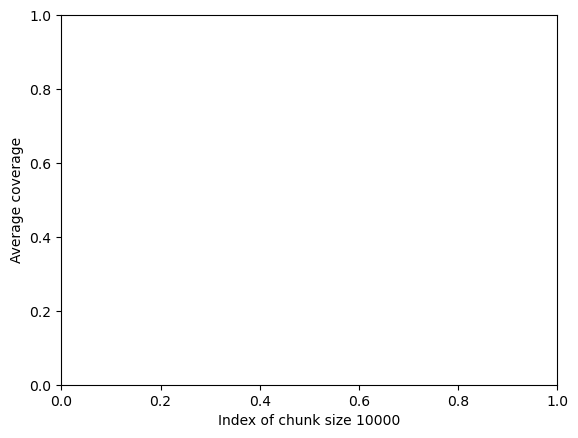

In [13]:
if visualize_coverage:
    print('Starting Visualize Coverage')
    save_dir = out_dir + "Coverage_output/"
    df = pd.DataFrame(pd.read_csv(save_dir + "/chunked_windows_coverage.tsv", dtype={'id': 'object'}, sep = "\t"))
    print('loaded data')
    trimmed_mean = pd.DataFrame(pd.read_csv(save_dir + "/chunked_coverage.tsv", dtype={'id': 'object'}, sep = "\t"))
    print('loaded trimmed_mean')
    
    # Get a list of unique ids
    unique_ids = df['id'].unique()
    print('Length of unique ids: ', len(unique_ids))
    
    #Plotting
    #--------------- 
    fig, ax = plt.subplots()
    plt.xlabel('Index of chunk size ' + str(chunk_size))
    plt.ylabel('Average coverage')
    gc.enable()
    
    for id in unique_ids:
        print(id)
        
        # added to resume if crashes for whatever reason
        save_path = os.path.join(save_dir, "Coverage_" + str(id) + ".png")
        
        # Skip if the plot already exists
        if os.path.exists(save_path):
            print(f'Skipping {id} (already exists)')
            continue
            
        # Filter the dataframe to get only the rows for this id
        search_str = f"id == '{id}'"
        #print(search_str)
        df_id = df.query(search_str)
        trimmed_mean_coverage = float(trimmed_mean.loc[trimmed_mean['id'] == id, 'average_coverage'])
        ax.axhline(y=trimmed_mean_coverage, color='black')
        # filtered colors
        colors = ['red' if abs(coverage - trimmed_mean_coverage) / trimmed_mean_coverage * 100 >= threshold_pct else 'blue' for coverage in df_id['average_coverage']]
        plt.bar(df_id['index'], df_id['average_coverage'], label=f"id={id}", color=colors, width=1)
        plt.savefig(save_path)
        plt.clf()
        
    print('Finished Visualize Coverage')

else :
    print("Coverage visualization is turned off.")

# Visualize individual Contigs GC vs Coverage

                   id  index  average_coverage  gc_content
0           CLA1_hapA      0             50.76        0.53
1           CLA1_hapA      1             49.98        0.45
2           CLA1_hapA      2             87.66        0.39
3           CLA1_hapA      3             85.66        0.39
4           CLA1_hapA      4             52.07        0.46
...               ...    ...               ...         ...
84470  CLA_hapA_sca22     99             18.22        0.37
84471  CLA_hapA_sca22    100             21.35        0.37
84472  CLA_hapA_sca22    101             22.60        0.37
84473  CLA_hapA_sca22    102             41.25        0.38
84474  CLA_hapA_sca22    103              6.08        0.37

[84475 rows x 4 columns]
             id  index  average_coverage  gc_content  Z_coverage      Z_gc
0     CLA1_hapA      0             50.76        0.53    0.071813  2.681174
1     CLA1_hapA      1             49.98        0.45    0.036176  0.732661
2     CLA1_hapA      2             87.66 

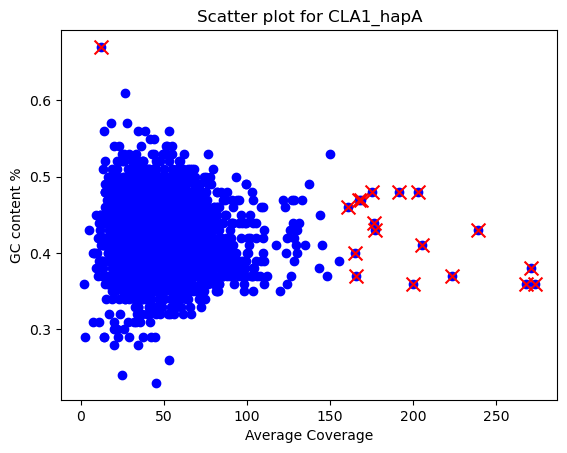

             id  index  average_coverage  gc_content  Z_coverage      Z_gc
3589  CLA2_hapA      0             84.26        0.41    1.375509  0.125272
3590  CLA2_hapA      1             37.11        0.52   -0.453376  2.442776
3591  CLA2_hapA      2             83.18        0.44    1.333617  0.757318
3592  CLA2_hapA      3             79.85        0.40    1.204451 -0.085410
3593  CLA2_hapA      4             93.33        0.40    1.727321 -0.085410
...         ...    ...               ...         ...         ...       ...
7326  CLA2_hapA   3737            103.39        0.43    2.117535  0.546636
7327  CLA2_hapA   3738             81.08        0.43    1.252161  0.546636
7328  CLA2_hapA   3739            100.24        0.43    1.995351  0.546636
7329  CLA2_hapA   3740            106.90        0.43    2.253683  0.546636
7330  CLA2_hapA   3741             37.52        0.43   -0.437472  0.546636

[3742 rows x 6 columns]


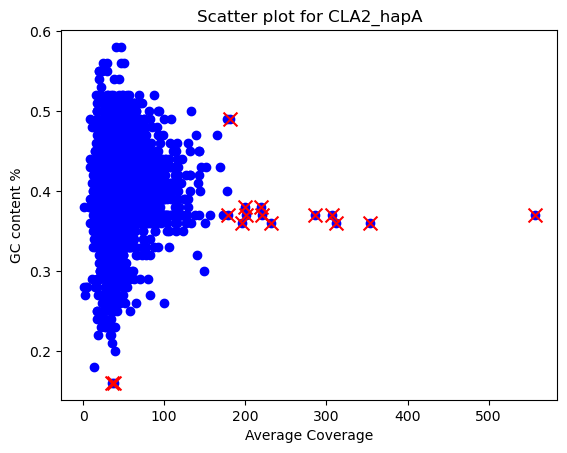

              id  index  average_coverage  gc_content  Z_coverage      Z_gc
7331   CLA3_hapA      0             65.81        0.45    0.375116  0.737947
7332   CLA3_hapA      1             62.35        0.45    0.275038  0.737947
7333   CLA3_hapA      2             68.00        0.31    0.438461 -2.152868
7334   CLA3_hapA      3            159.99        0.51    3.099216  1.976867
7335   CLA3_hapA      4             10.69        0.52   -1.219197  2.183354
...          ...    ...               ...         ...         ...       ...
11505  CLA3_hapA   4174             41.59        0.48   -0.325433  1.357407
11506  CLA3_hapA   4175             50.72        0.45   -0.061353  0.737947
11507  CLA3_hapA   4176             31.63        0.50   -0.613520  1.770381
11508  CLA3_hapA   4177             38.24        0.44   -0.422330  0.531460
11509  CLA3_hapA   4178             26.83        0.41   -0.752357 -0.088000

[4179 rows x 6 columns]


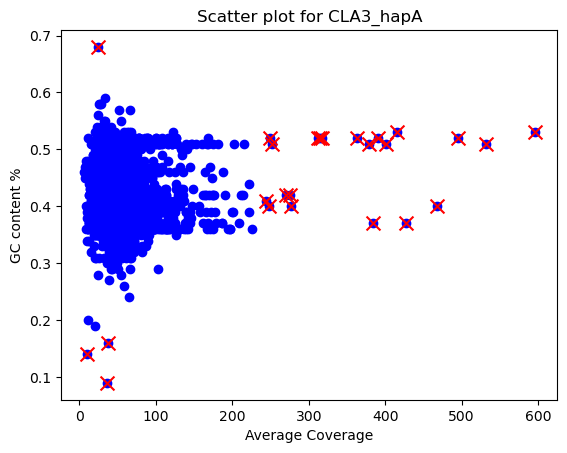

              id  index  average_coverage  gc_content  Z_coverage      Z_gc
11510  CLA4_hapA      0             10.45        0.37   -1.558232 -0.979110
11511  CLA4_hapA      1             24.20        0.37   -0.977082 -0.979110
11512  CLA4_hapA      2             37.27        0.37   -0.424672 -0.979110
11513  CLA4_hapA      3             23.73        0.37   -0.996947 -0.979110
11514  CLA4_hapA      4             16.94        0.37   -1.283929 -0.979110
...          ...    ...               ...         ...         ...       ...
16475  CLA4_hapA   4965             87.26        0.43    1.688179  0.364705
16476  CLA4_hapA   4966             28.57        0.48   -0.792382  1.484551
16477  CLA4_hapA   4967             24.89        0.42   -0.947919  0.140736
16478  CLA4_hapA   4968             51.69        0.40    0.184796 -0.307203
16479  CLA4_hapA   4969             52.44        0.47    0.216495  1.260581

[4970 rows x 6 columns]


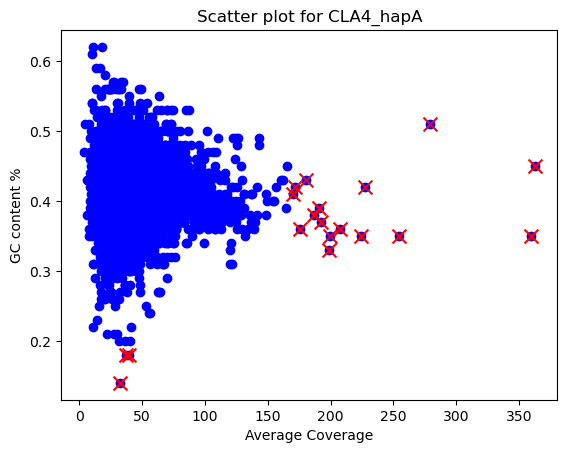

              id  index  average_coverage  gc_content  Z_coverage      Z_gc
16480  CLA5_hapA      0             31.80        0.46   -0.755727  0.839136
16481  CLA5_hapA      1             29.96        0.41   -0.834021 -0.544276
16482  CLA5_hapA      2             54.87        0.42    0.225928 -0.267593
16483  CLA5_hapA      3             54.45        0.43    0.208056  0.009089
16484  CLA5_hapA      4             65.22        0.45    0.666332  0.562453
...          ...    ...               ...         ...         ...       ...
20950  CLA5_hapA   4470             40.91        0.42   -0.368086 -0.267593
20951  CLA5_hapA   4471             60.14        0.45    0.450172  0.562453
20952  CLA5_hapA   4472             50.66        0.44    0.046788  0.285771
20953  CLA5_hapA   4473             55.65        0.43    0.259118  0.009089
20954  CLA5_hapA   4474             54.01        0.46    0.189334  0.839136

[4475 rows x 6 columns]


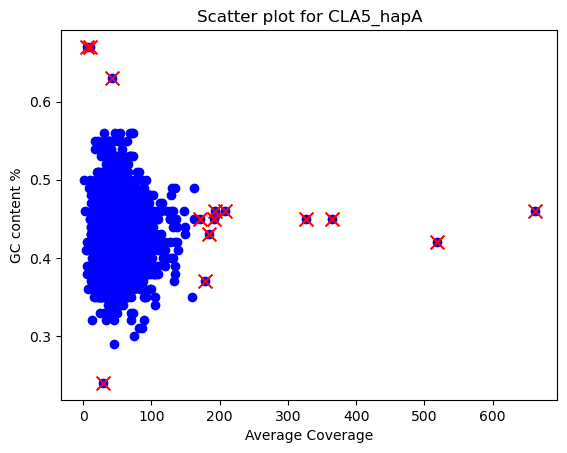

              id  index  average_coverage  gc_content  Z_coverage      Z_gc
20955  CLA6_hapA      0             11.15        0.42   -1.303361  0.068328
20956  CLA6_hapA      1             32.44        0.42   -0.614515  0.068328
20957  CLA6_hapA      2             27.53        0.42   -0.773380  0.068328
20958  CLA6_hapA      3             17.35        0.41   -1.102757 -0.171815
20959  CLA6_hapA      4             22.64        0.42   -0.931598  0.068328
...          ...    ...               ...         ...         ...       ...
26018  CLA6_hapA   5063             35.96        0.47   -0.500624  1.269040
26019  CLA6_hapA   5064             30.39        0.44   -0.680843  0.548613
26020  CLA6_hapA   5065             35.49        0.40   -0.515831 -0.411957
26021  CLA6_hapA   5066             45.55        0.46   -0.190336  1.028898
26022  CLA6_hapA   5067             62.15        0.67    0.346763  6.071891

[5068 rows x 6 columns]


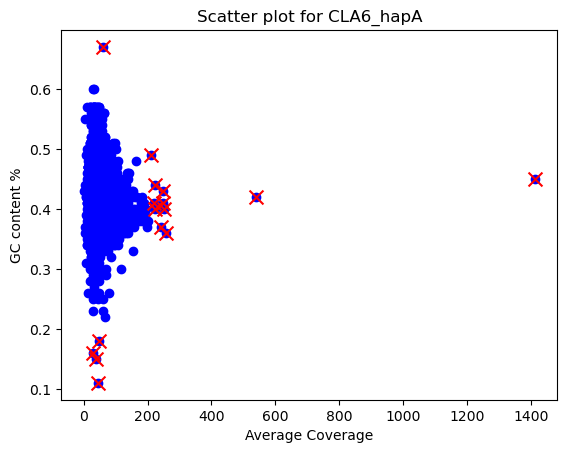

              id  index  average_coverage  gc_content  Z_coverage      Z_gc
26023  CLA7_hapA      0             34.05        0.52   -0.764038  2.390104
26024  CLA7_hapA      1             69.77        0.44    0.727930  0.649008
26025  CLA7_hapA      2             59.73        0.43    0.308575  0.431371
26026  CLA7_hapA      3             34.81        0.51   -0.732294  2.172467
26027  CLA7_hapA      4             37.62        0.49   -0.614925  1.737193
...          ...    ...               ...         ...         ...       ...
30646  CLA7_hapA   4623              3.64        0.50   -2.034216  1.954830
30647  CLA7_hapA   4624              2.67        0.50   -2.074731  1.954830
30648  CLA7_hapA   4625              7.45        0.50   -1.875078  1.954830
30649  CLA7_hapA   4626             19.40        0.50   -1.375945  1.954830
30650  CLA7_hapA   4627             23.45        0.50   -1.206783  1.954830

[4628 rows x 6 columns]


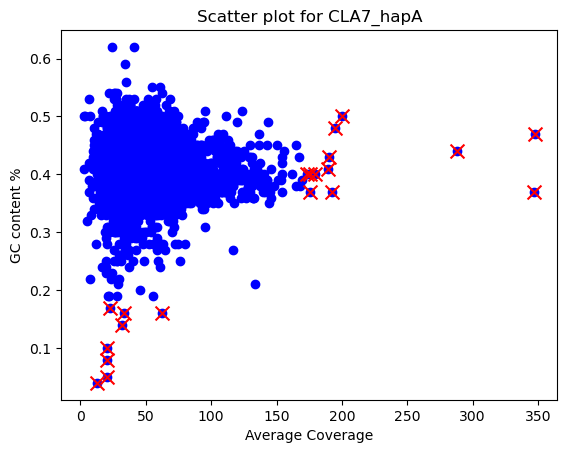

              id  index  average_coverage  gc_content  Z_coverage      Z_gc
30651  CLA8_hapA      0             47.01        0.40   -0.002985 -0.256591
30652  CLA8_hapA      1             88.02        0.41    1.561547 -0.049466
30653  CLA8_hapA      2             71.73        0.39    0.940083 -0.463717
30654  CLA8_hapA      3             61.00        0.40    0.530733 -0.256591
30655  CLA8_hapA      4             63.63        0.40    0.631068 -0.256591
...          ...    ...               ...         ...         ...       ...
35633  CLA8_hapA   4982             32.16        0.46   -0.569513  0.986161
35634  CLA8_hapA   4983             31.95        0.45   -0.577525  0.779036
35635  CLA8_hapA   4984             71.11        0.42    0.916430  0.157660
35636  CLA8_hapA   4985             58.43        0.42    0.432688  0.157660
35637  CLA8_hapA   4986             15.36        0.40   -1.210433 -0.256591

[4987 rows x 6 columns]


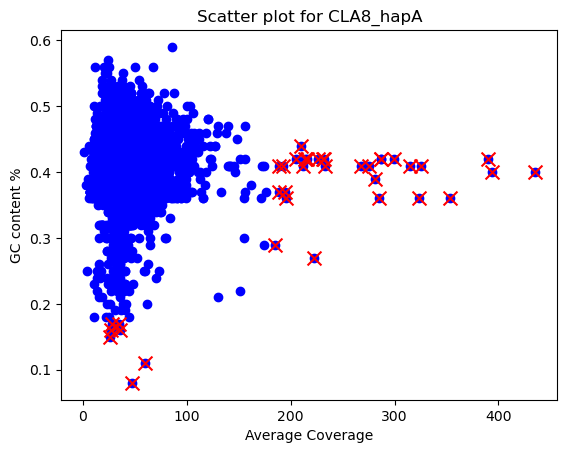

              id  index  average_coverage  gc_content  Z_coverage      Z_gc
35638  CLA9_hapA      0             13.65        0.48   -1.950387  1.338910
35639  CLA9_hapA      1             62.89        0.47    0.868379  1.072231
35640  CLA9_hapA      2             91.56        0.47    2.509606  1.072231
35641  CLA9_hapA      3            153.42        0.47    6.050809  1.072231
35642  CLA9_hapA      4             52.02        0.49    0.246121  1.605590
...          ...    ...               ...         ...         ...       ...
39988  CLA9_hapA   4350             27.23        0.44   -1.172994  0.272191
39989  CLA9_hapA   4351             39.69        0.43   -0.459716  0.005511
39990  CLA9_hapA   4352             48.91        0.43    0.068088  0.005511
39991  CLA9_hapA   4353             78.73        0.45    1.775147  0.538871
39992  CLA9_hapA   4354            327.92        0.49   16.040140  1.605590

[4355 rows x 6 columns]


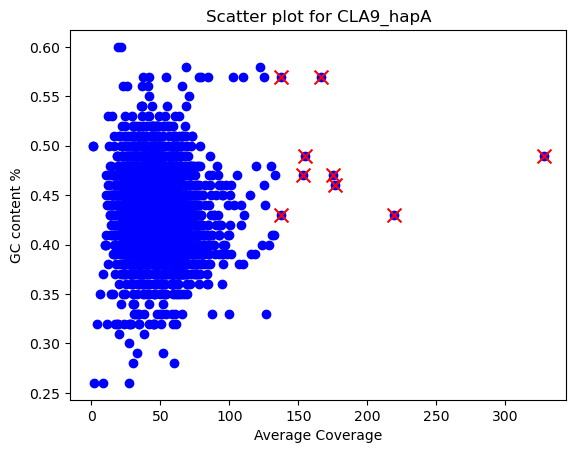

               id  index  average_coverage  gc_content  Z_coverage      Z_gc
39993  CLA10_hapA      0             44.97        0.47   -0.138431  1.306937
39994  CLA10_hapA      1            204.58        0.44    6.617109  0.638660
39995  CLA10_hapA      2             92.06        0.49    1.854667  1.752455
39996  CLA10_hapA      3             44.09        0.45   -0.175677  0.861419
39997  CLA10_hapA      4             33.20        0.47   -0.636599  1.306937
...           ...    ...               ...         ...         ...       ...
43854  CLA10_hapA   3861             61.91        0.46    0.578560  1.084178
43855  CLA10_hapA   3862            156.79        0.48    4.594383  1.529696
43856  CLA10_hapA   3863             69.46        0.50    0.898116  1.975214
43857  CLA10_hapA   3864             95.39        0.47    1.995610  1.306937
43858  CLA10_hapA   3865             17.93        0.62   -1.282907  4.648322

[3866 rows x 6 columns]


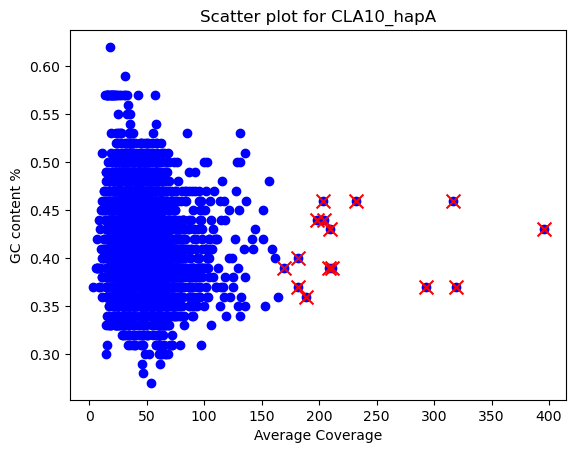

               id  index  average_coverage  gc_content  Z_coverage      Z_gc
43859  CLA11_hapA      0             88.76        0.43    1.632774  0.226482
43860  CLA11_hapA      1             64.01        0.49    0.613348  1.761206
43861  CLA11_hapA      2             69.48        0.48    0.838652  1.505419
43862  CLA11_hapA      3             74.67        0.45    1.052422  0.738057
43863  CLA11_hapA      4             58.92        0.47    0.403697  1.249631
...           ...    ...               ...         ...         ...       ...
49414  CLA11_hapA   5555             38.67        0.37   -0.430378 -1.308242
49415  CLA11_hapA   5556             49.82        0.44    0.028878  0.482269
49416  CLA11_hapA   5557             37.08        0.46   -0.495869  0.993844
49417  CLA11_hapA   5558             58.57        0.45    0.389281  0.738057
49418  CLA11_hapA   5559            136.87        0.58    3.614372  4.063292

[5560 rows x 6 columns]


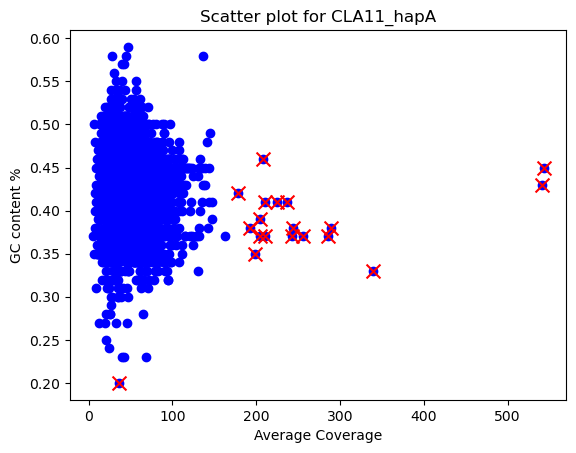

               id  index  average_coverage  gc_content  Z_coverage      Z_gc
49419  CLA12_hapA      0             21.26        0.43   -1.363937  0.235868
49420  CLA12_hapA      1             23.03        0.48   -1.276248  1.422656
49421  CLA12_hapA      2             22.50        0.32   -1.302505 -2.375064
49422  CLA12_hapA      3             56.61        0.44    0.387378  0.473226
49423  CLA12_hapA      4             36.92        0.45   -0.588107  0.710583
...           ...    ...               ...         ...         ...       ...
53080  CLA12_hapA   3661             87.06        0.41    1.895937 -0.238847
53081  CLA12_hapA   3662             49.27        0.37    0.023739 -1.188277
53082  CLA12_hapA   3663             63.51        0.36    0.729219 -1.425634
53083  CLA12_hapA   3664             54.31        0.39    0.273431 -0.713562
53084  CLA12_hapA   3665             31.00        0.53   -0.881397  2.609443

[3666 rows x 6 columns]


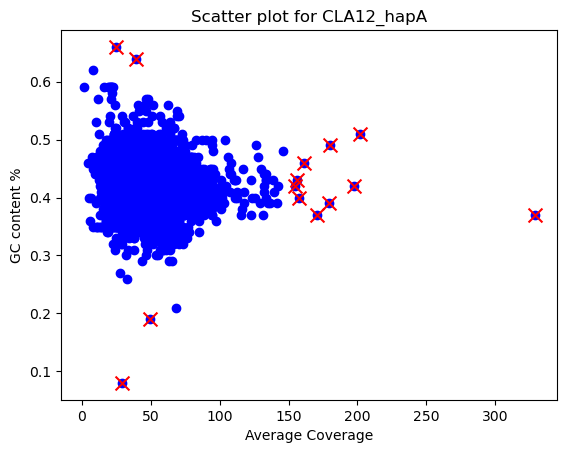

               id  index  average_coverage  gc_content  Z_coverage      Z_gc
53085  CLA13_hapA      0             36.75        0.52   -0.393401  2.234248
53086  CLA13_hapA      1             63.97        0.44    0.944023  0.548664
53087  CLA13_hapA      2             81.04        0.44    1.782738  0.548664
53088  CLA13_hapA      3             52.64        0.49    0.387336  1.602154
53089  CLA13_hapA      4             61.34        0.44    0.814801  0.548664
...           ...    ...               ...         ...         ...       ...
57449  CLA13_hapA   4364             35.83        0.41   -0.438604 -0.083430
57450  CLA13_hapA   4365             25.63        0.45   -0.939770  0.759362
57451  CLA13_hapA   4366             29.86        0.47   -0.731934  1.180758
57452  CLA13_hapA   4367             16.13        0.40   -1.406542 -0.294128
57453  CLA13_hapA   4368              4.69        0.40   -1.968633 -0.294128

[4369 rows x 6 columns]


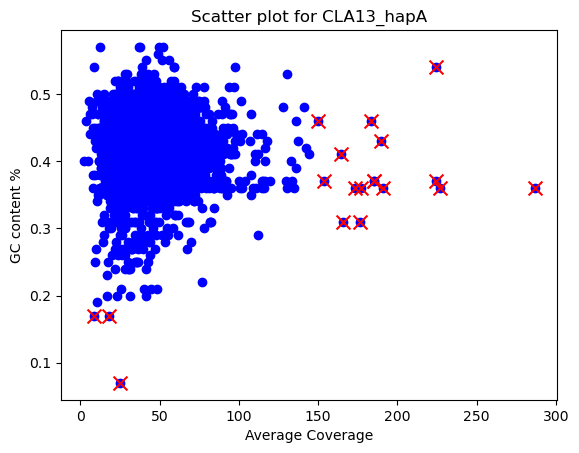

               id  index  average_coverage  gc_content  Z_coverage      Z_gc
57454  CLA14_hapA      0             49.05        0.50    0.082603  1.755267
57455  CLA14_hapA      1             38.54        0.46   -0.345155  0.795185
57456  CLA14_hapA      2             28.66        0.40   -0.747272 -0.644939
57457  CLA14_hapA      3             25.45        0.34   -0.877919 -2.085062
57458  CLA14_hapA      4             22.41        0.36   -1.001648 -1.605021
...           ...    ...               ...         ...         ...       ...
60922  CLA14_hapA   3468             38.74        0.51   -0.337015  1.995288
60923  CLA14_hapA   3469             71.55        0.42    0.998354 -0.164898
60924  CLA14_hapA   3470             58.97        0.44    0.486347  0.315144
60925  CLA14_hapA   3471             43.75        0.47   -0.133108  1.035206
60926  CLA14_hapA   3472             39.00        0.36   -0.326433 -1.605021

[3473 rows x 6 columns]


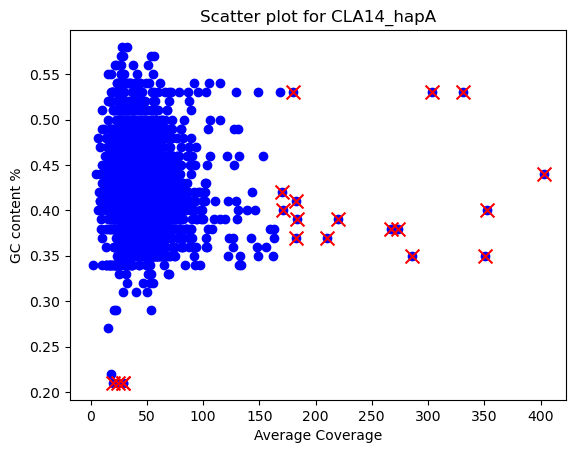

               id  index  average_coverage  gc_content  Z_coverage      Z_gc
60927  CLA15_hapA      0             50.50        0.46    0.063695  0.949315
60928  CLA15_hapA      1             45.57        0.44   -0.142861  0.406776
60929  CLA15_hapA      2             48.95        0.45   -0.001246  0.678045
60930  CLA15_hapA      3             29.35        0.42   -0.822442 -0.135763
60931  CLA15_hapA      4             74.74        0.44    1.079297  0.406776
...           ...    ...               ...         ...         ...       ...
65148  CLA15_hapA   4221             44.74        0.45   -0.177636  0.678045
65149  CLA15_hapA   4222             77.51        0.44    1.195353  0.406776
65150  CLA15_hapA   4223             57.96        0.48    0.376252  1.491854
65151  CLA15_hapA   4224             28.25        0.50   -0.868530  2.034393
65152  CLA15_hapA   4225              8.16        0.44   -1.710256  0.406776

[4226 rows x 6 columns]


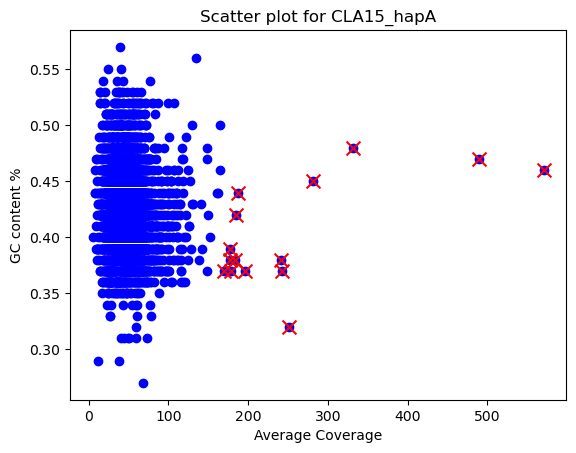

               id  index  average_coverage  gc_content  Z_coverage      Z_gc
65153  CLA16_hapA      0             42.46        0.46   -0.232397  1.070187
65154  CLA16_hapA      1             35.46        0.41   -0.488151 -0.016823
65155  CLA16_hapA      2             34.01        0.41   -0.541128 -0.016823
65156  CLA16_hapA      3             30.93        0.43   -0.653660  0.417981
65157  CLA16_hapA      4             13.68        0.41   -1.283910 -0.016823
...           ...    ...               ...         ...         ...       ...
70705  CLA16_hapA   5552             58.01        0.42    0.335742  0.200579
70706  CLA16_hapA   5553             55.02        0.45    0.226498  0.852785
70707  CLA16_hapA   5554             39.73        0.57   -0.332141  3.461607
70708  CLA16_hapA   5555             38.12        0.56   -0.390964  3.244205
70709  CLA16_hapA   5556             33.72        0.45   -0.551724  0.852785

[5557 rows x 6 columns]


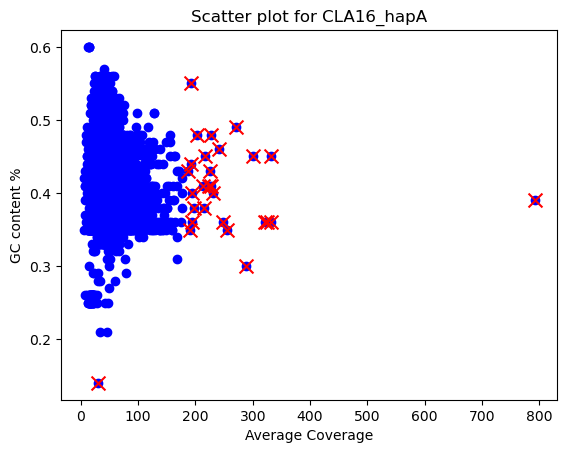

               id  index  average_coverage  gc_content  Z_coverage      Z_gc
70710  CLA17_hapA      0             30.38        0.44   -0.861006  0.089856
70711  CLA17_hapA      1             54.01        0.41    0.253896 -0.665925
70712  CLA17_hapA      2             55.10        0.42    0.305324 -0.413998
70713  CLA17_hapA      3             38.73        0.44   -0.467040  0.089856
70714  CLA17_hapA      4             49.65        0.42    0.048184 -0.413998
...           ...    ...               ...         ...         ...       ...
75146  CLA17_hapA   4436             41.45        0.45   -0.338706  0.341784
75147  CLA17_hapA   4437             40.20        0.38   -0.397683 -1.421707
75148  CLA17_hapA   4438             85.74        0.45    1.750968  0.341784
75149  CLA17_hapA   4439            282.61        0.49   11.039615  1.349493
75150  CLA17_hapA   4440            102.96        0.47    2.563436  0.845638

[4441 rows x 6 columns]


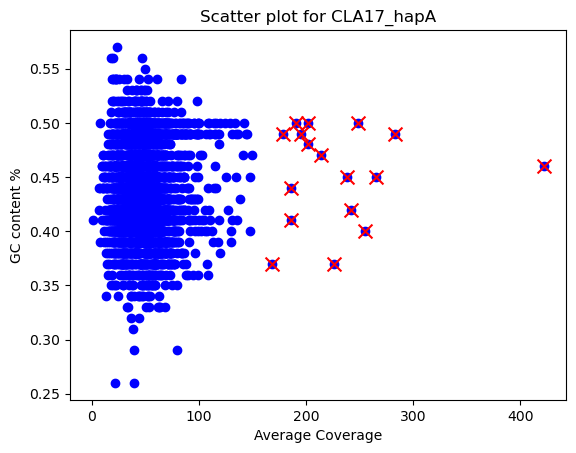

               id  index  average_coverage  gc_content  Z_coverage      Z_gc
75151  CLA18_hapA      0             25.86        0.39   -0.779342 -0.406960
75152  CLA18_hapA      1             12.36        0.47   -1.298350  0.966052
75153  CLA18_hapA      2             40.95        0.48   -0.199207  1.137679
75154  CLA18_hapA      3             40.19        0.43   -0.228425  0.279546
75155  CLA18_hapA      4             35.37        0.48   -0.413730  1.137679
...           ...    ...               ...         ...         ...       ...
79187  CLA18_hapA   4036              2.81        0.38   -1.665500 -0.578587
79188  CLA18_hapA   4037              9.82        0.38   -1.396000 -0.578587
79189  CLA18_hapA   4038             21.63        0.38   -0.941965 -0.578587
79190  CLA18_hapA   4039              4.00        0.38   -1.619750 -0.578587
79191  CLA18_hapA   4040              2.37        0.38   -1.682416 -0.578587

[4041 rows x 6 columns]


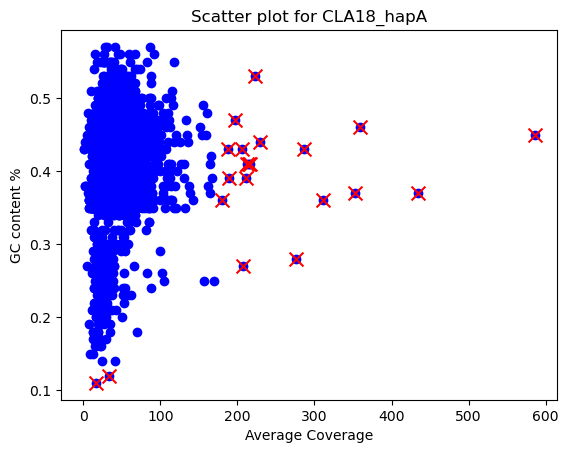

                  id  index  average_coverage  gc_content  Z_coverage  \
79192  CLA_hapA_sca1      0             22.25        0.39   -2.077950   
79193  CLA_hapA_sca1      1             58.08        0.39   -0.350564   
79194  CLA_hapA_sca1      2             57.77        0.40   -0.365509   
79195  CLA_hapA_sca1      3             57.50        0.38   -0.378526   
79196  CLA_hapA_sca1      4             64.89        0.39   -0.022250   
...              ...    ...               ...         ...         ...   
79807  CLA_hapA_sca1    615             63.91        0.43   -0.069496   
79808  CLA_hapA_sca1    616             40.34        0.36   -1.205820   
79809  CLA_hapA_sca1    617             30.43        0.35   -1.683587   
79810  CLA_hapA_sca1    618             10.89        0.37   -2.625622   
79811  CLA_hapA_sca1    619              1.00        0.39   -3.102425   

           Z_gc  
79192  0.079793  
79193  0.079793  
79194  0.457439  
79195 -0.297853  
79196  0.079793  
...         ...

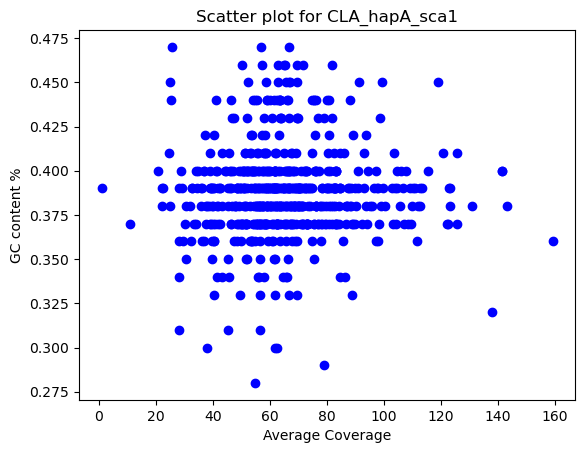

                  id  index  average_coverage  gc_content  Z_coverage  \
79812  CLA_hapA_sca2      0            162.03        0.30    4.541210   
79813  CLA_hapA_sca2      1             31.63        0.44   -1.126880   
79814  CLA_hapA_sca2      2             37.90        0.40   -0.854343   
79815  CLA_hapA_sca2      3             34.14        0.45   -1.017778   
79816  CLA_hapA_sca2      4             34.78        0.38   -0.989959   
...              ...    ...               ...         ...         ...   
80394  CLA_hapA_sca2    582             87.40        0.39    1.297271   
80395  CLA_hapA_sca2    583             70.21        0.39    0.550075   
80396  CLA_hapA_sca2    584             59.41        0.39    0.080632   
80397  CLA_hapA_sca2    585             53.85        0.35   -0.161045   
80398  CLA_hapA_sca2    586             34.71        0.32   -0.993002   

           Z_gc  
79812 -1.979638  
79813  0.594111  
79814 -0.141246  
79815  0.777950  
79816 -0.508924  
...         ...

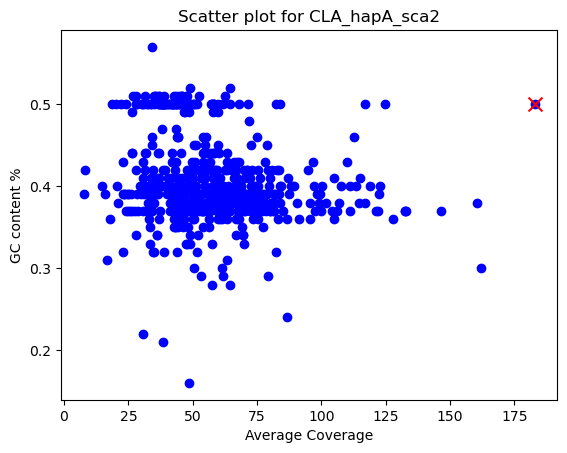

                  id  index  average_coverage  gc_content  Z_coverage  \
80399  CLA_hapA_sca3      0             10.11        0.38   -1.760281   
80400  CLA_hapA_sca3      1             22.47        0.41   -1.198788   
80401  CLA_hapA_sca3      2             35.14        0.36   -0.623213   
80402  CLA_hapA_sca3      3             37.36        0.38   -0.522363   
80403  CLA_hapA_sca3      4             34.51        0.39   -0.651833   
...              ...    ...               ...         ...         ...   
80924  CLA_hapA_sca3    525             41.75        0.38   -0.322933   
80925  CLA_hapA_sca3    526             30.67        0.43   -0.826277   
80926  CLA_hapA_sca3    527             29.05        0.36   -0.899871   
80927  CLA_hapA_sca3    528             16.74        0.34   -1.459092   
80928  CLA_hapA_sca3    529              4.90        0.38   -1.996962   

           Z_gc  
80399 -0.381288  
80400  0.816830  
80401 -1.180033  
80402 -0.381288  
80403  0.018085  
...         ...

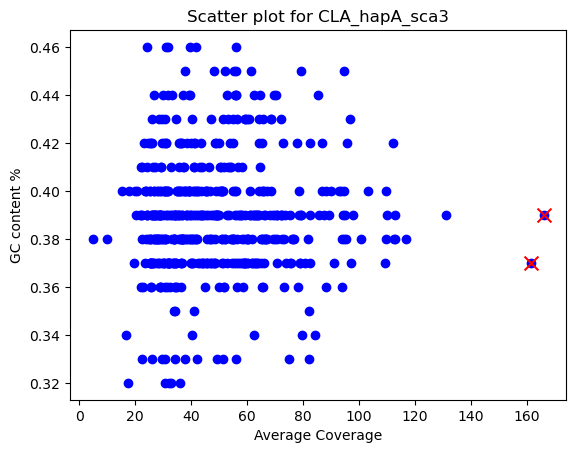

                  id  index  average_coverage  gc_content  Z_coverage  \
80929  CLA_hapA_sca4      0             20.34        0.37   -1.056507   
80930  CLA_hapA_sca4      1             28.28        0.37   -0.835555   
80931  CLA_hapA_sca4      2             20.70        0.37   -1.046489   
80932  CLA_hapA_sca4      3             20.45        0.37   -1.053445   
80933  CLA_hapA_sca4      4             30.95        0.37   -0.761255   
...              ...    ...               ...         ...         ...   
81320  CLA_hapA_sca4    391             39.70        0.40   -0.517764   
81321  CLA_hapA_sca4    392             34.57        0.39   -0.660519   
81322  CLA_hapA_sca4    393             59.11        0.26    0.022370   
81323  CLA_hapA_sca4    394             73.53        0.37    0.423645   
81324  CLA_hapA_sca4    395             24.12        0.37   -0.951318   

           Z_gc  
80929 -0.559471  
80930 -0.559471  
80931 -0.559471  
80932 -0.559471  
80933 -0.559471  
...         ...

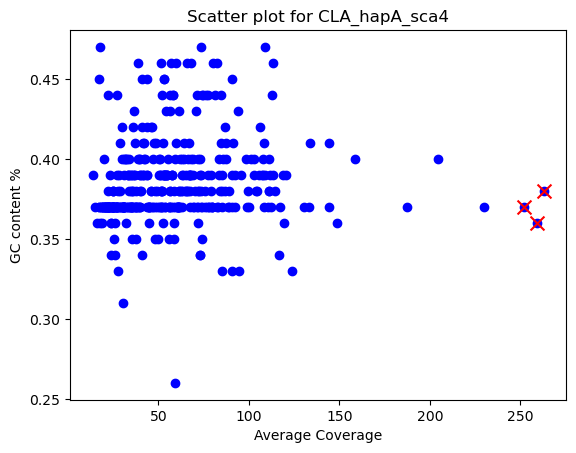

                  id  index  average_coverage  gc_content  Z_coverage  \
81325  CLA_hapA_sca5      0             23.59        0.52   -1.098586   
81326  CLA_hapA_sca5      1             52.49        0.54   -0.003187   
81327  CLA_hapA_sca5      2            127.48        0.53    2.839164   
81328  CLA_hapA_sca5      3            122.27        0.51    2.641689   
81329  CLA_hapA_sca5      4            198.15        0.43    5.517775   
...              ...    ...               ...         ...         ...   
81655  CLA_hapA_sca5    330             45.97        0.38   -0.250315   
81656  CLA_hapA_sca5    331             63.10        0.37    0.398964   
81657  CLA_hapA_sca5    332             66.93        0.37    0.544133   
81658  CLA_hapA_sca5    333             42.96        0.36   -0.364404   
81659  CLA_hapA_sca5    334             28.17        0.28   -0.924990   

           Z_gc  
81325  0.914253  
81326  1.529262  
81327  1.221757  
81328  0.606748  
81329 -1.853289  
...         ...

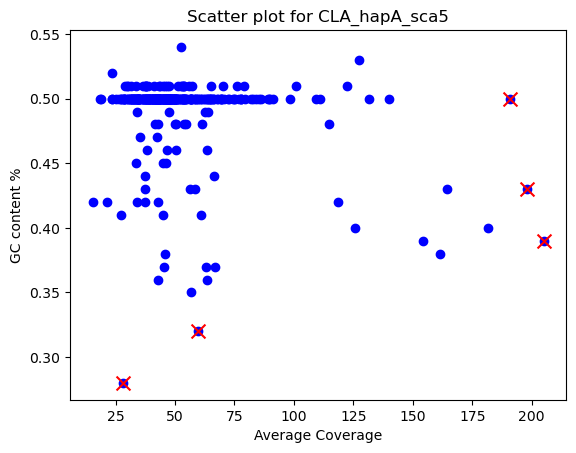

                  id  index  average_coverage  gc_content  Z_coverage  \
81660  CLA_hapA_sca6      0             12.23        0.43   -1.436374   
81661  CLA_hapA_sca6      1             29.89        0.34   -0.726877   
81662  CLA_hapA_sca6      2             35.05        0.36   -0.519572   
81663  CLA_hapA_sca6      3             51.62        0.39    0.146134   
81664  CLA_hapA_sca6      4             62.63        0.39    0.588465   
...              ...    ...               ...         ...         ...   
81924  CLA_hapA_sca6    264             37.96        0.39   -0.402662   
81925  CLA_hapA_sca6    265             45.52        0.41   -0.098936   
81926  CLA_hapA_sca6    266             12.33        0.45   -1.432356   
81927  CLA_hapA_sca6    267             10.04        0.46   -1.524358   
81928  CLA_hapA_sca6    268              4.82        0.44   -1.734074   

           Z_gc  
81660  1.379612  
81661 -1.704452  
81662 -1.019104  
81663  0.008917  
81664  0.008917  
...         ...

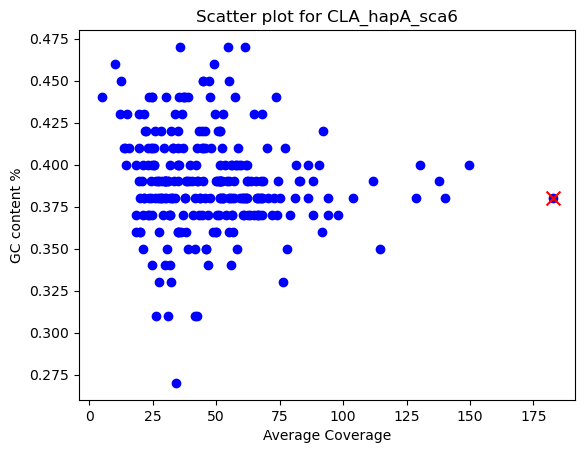

                  id  index  average_coverage  gc_content  Z_coverage  \
81929  CLA_hapA_sca7      0             30.96        0.41   -1.380417   
81930  CLA_hapA_sca7      1             59.70        0.40   -0.194772   
81931  CLA_hapA_sca7      2             61.97        0.38   -0.101125   
81932  CLA_hapA_sca7      3             84.59        0.38    0.832044   
81933  CLA_hapA_sca7      4             61.80        0.36   -0.108138   
...              ...    ...               ...         ...         ...   
82175  CLA_hapA_sca7    246             27.39        0.38   -1.527694   
82176  CLA_hapA_sca7    247             28.35        0.39   -1.488090   
82177  CLA_hapA_sca7    248             25.20        0.40   -1.618040   
82178  CLA_hapA_sca7    249             25.84        0.37   -1.591638   
82179  CLA_hapA_sca7    250             12.68        0.34   -2.134542   

           Z_gc  
81929  0.716409  
81930  0.351665  
81931 -0.377822  
81932 -0.377822  
81933 -1.107310  
...         ...

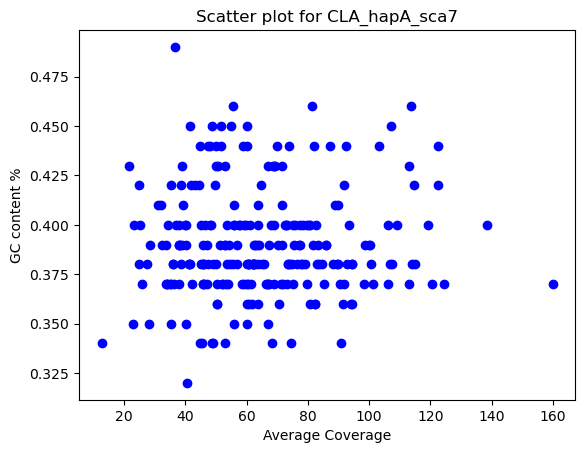

                  id  index  average_coverage  gc_content  Z_coverage  \
82180  CLA_hapA_sca8      0              9.62        0.37   -1.866838   
82181  CLA_hapA_sca8      1             28.42        0.35   -1.260691   
82182  CLA_hapA_sca8      2             33.74        0.37   -1.089164   
82183  CLA_hapA_sca8      3             28.28        0.44   -1.265204   
82184  CLA_hapA_sca8      4             40.07        0.38   -0.885073   
...              ...    ...               ...         ...         ...   
82394  CLA_hapA_sca8    214             47.27        0.38   -0.652932   
82395  CLA_hapA_sca8    215             39.77        0.37   -0.894745   
82396  CLA_hapA_sca8    216             30.42        0.34   -1.196207   
82397  CLA_hapA_sca8    217             23.44        0.37   -1.421255   
82398  CLA_hapA_sca8    218             11.89        0.48   -1.793648   

           Z_gc  
82180 -0.601909  
82181 -1.330185  
82182 -0.601909  
82183  1.947059  
82184 -0.237771  
...         ...

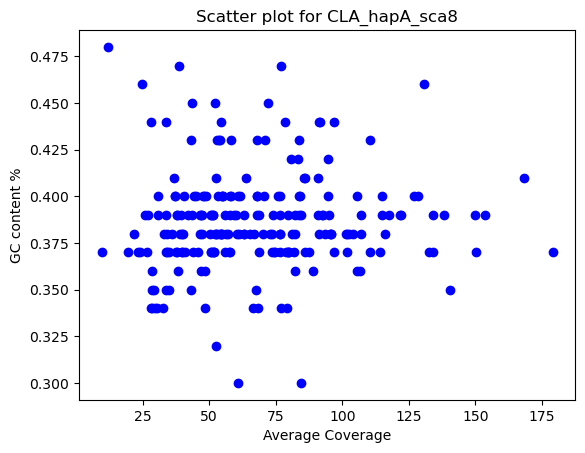

                  id  index  average_coverage  gc_content  Z_coverage  \
82399  CLA_hapA_sca9      0             20.42        0.36   -1.679349   
82400  CLA_hapA_sca9      1             54.09        0.34    0.105066   
82401  CLA_hapA_sca9      2             48.96        0.38   -0.166809   
82402  CLA_hapA_sca9      3             34.95        0.40   -0.909300   
82403  CLA_hapA_sca9      4             38.99        0.39   -0.695191   
...              ...    ...               ...         ...         ...   
82587  CLA_hapA_sca9    188             52.89        0.37    0.041470   
82588  CLA_hapA_sca9    189             58.24        0.40    0.325004   
82589  CLA_hapA_sca9    190             50.58        0.40   -0.080954   
82590  CLA_hapA_sca9    191             38.63        0.38   -0.714270   
82591  CLA_hapA_sca9    192              8.22        0.39   -2.325914   

           Z_gc  
82399 -1.195530  
82400 -1.947118  
82401 -0.443943  
82402  0.307645  
82403 -0.068149  
...         ...

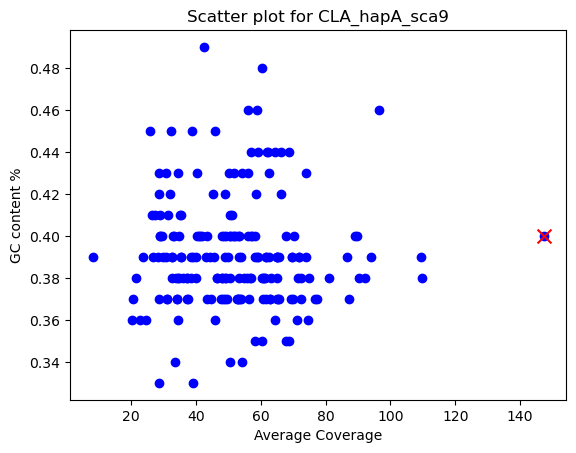

                   id  index  average_coverage  gc_content  Z_coverage  \
82592  CLA_hapA_sca10      0              8.73        0.32   -1.501849   
82593  CLA_hapA_sca10      1             34.09        0.31   -0.618625   
82594  CLA_hapA_sca10      2             51.65        0.30   -0.007055   
82595  CLA_hapA_sca10      3             46.17        0.31   -0.197909   
82596  CLA_hapA_sca10      4             31.75        0.31   -0.700121   
...               ...    ...               ...         ...         ...   
82778  CLA_hapA_sca10    186             25.34        0.37   -0.923365   
82779  CLA_hapA_sca10    187             45.37        0.37   -0.225771   
82780  CLA_hapA_sca10    188             71.09        0.36    0.669991   
82781  CLA_hapA_sca10    189             51.19        0.37   -0.023075   
82782  CLA_hapA_sca10    190             24.16        0.36   -0.964462   

           Z_gc  
82592 -2.380943  
82593 -2.915955  
82594 -3.450967  
82595 -2.915955  
82596 -2.915955  
...

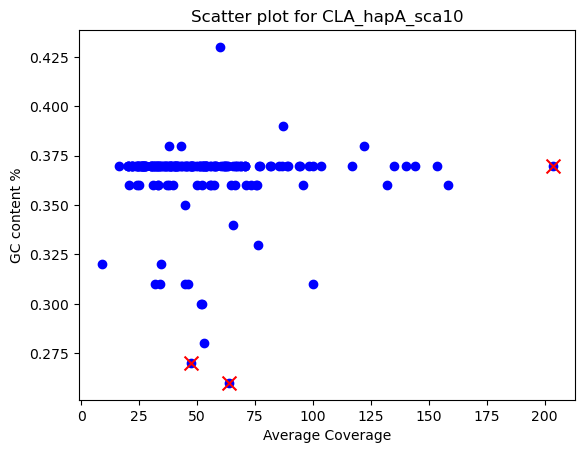

                   id  index  average_coverage  gc_content  Z_coverage  \
82783  CLA_hapA_sca11      0             16.09        0.36   -1.865817   
82784  CLA_hapA_sca11      1             56.75        0.39   -0.636521   
82785  CLA_hapA_sca11      2             78.37        0.37    0.017129   
82786  CLA_hapA_sca11      3            102.74        0.40    0.753921   
82787  CLA_hapA_sca11      4            157.64        0.41    2.413743   
...               ...    ...               ...         ...         ...   
82958  CLA_hapA_sca11    175             68.44        0.34   -0.283090   
82959  CLA_hapA_sca11    176             61.77        0.33   -0.484748   
82960  CLA_hapA_sca11    177             44.92        0.32   -0.994184   
82961  CLA_hapA_sca11    178              6.68        0.36   -2.150315   
82962  CLA_hapA_sca11    179              4.52        0.37   -2.215619   

           Z_gc  
82783 -1.026060  
82784  0.033352  
82785 -0.672923  
82786  0.386489  
82787  0.739627  
...

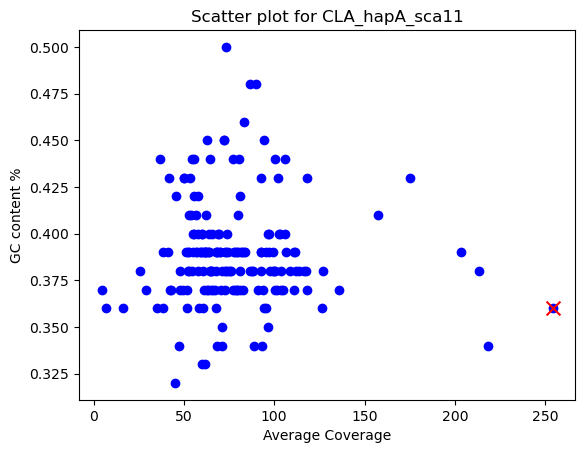

                   id  index  average_coverage  gc_content  Z_coverage  \
82963  CLA_hapA_sca12      0             14.27        0.35   -2.215027   
82964  CLA_hapA_sca12      1             28.82        0.35   -1.669695   
82965  CLA_hapA_sca12      2             67.95        0.44   -0.203109   
82966  CLA_hapA_sca12      3             94.92        0.38    0.807723   
82967  CLA_hapA_sca12      4            107.49        0.38    1.278844   
...               ...    ...               ...         ...         ...   
83134  CLA_hapA_sca12    171             31.23        0.38   -1.579369   
83135  CLA_hapA_sca12    172             37.60        0.38   -1.340622   
83136  CLA_hapA_sca12    173             45.07        0.37   -1.060648   
83137  CLA_hapA_sca12    174             22.80        0.40   -1.895324   
83138  CLA_hapA_sca12    175              2.77        0.40   -2.646046   

           Z_gc  
82963 -1.500717  
82964 -1.500717  
82965  1.989938  
82966 -0.337166  
82967 -0.337166  
...

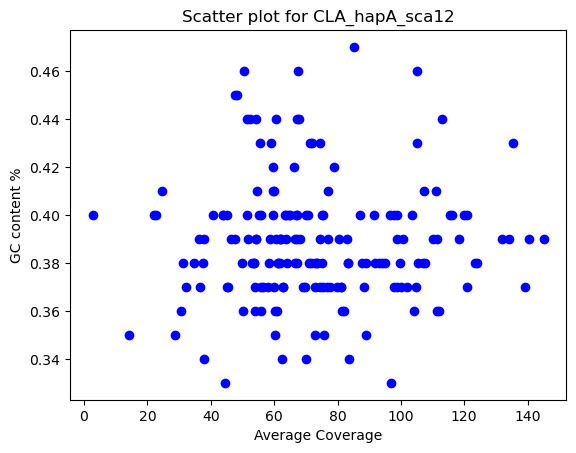

                   id  index  average_coverage  gc_content  Z_coverage  \
83139  CLA_hapA_sca13      0             25.01        0.37   -0.662370   
83140  CLA_hapA_sca13      1             55.50        0.34    0.892007   
83141  CLA_hapA_sca13      2             37.82        0.37   -0.009318   
83142  CLA_hapA_sca13      3             49.55        0.42    0.588676   
83143  CLA_hapA_sca13      4             49.21        0.38    0.571343   
...               ...    ...               ...         ...         ...   
83300  CLA_hapA_sca13    161             29.79        0.37   -0.418686   
83301  CLA_hapA_sca13    162             21.91        0.37   -0.820408   
83302  CLA_hapA_sca13    163             32.92        0.37   -0.259119   
83303  CLA_hapA_sca13    164             39.32        0.41    0.067152   
83304  CLA_hapA_sca13    165             31.59        0.48   -0.326922   

           Z_gc  
83139 -0.276469  
83140 -2.064542  
83141 -0.276469  
83142  2.703653  
83143  0.319555  
...

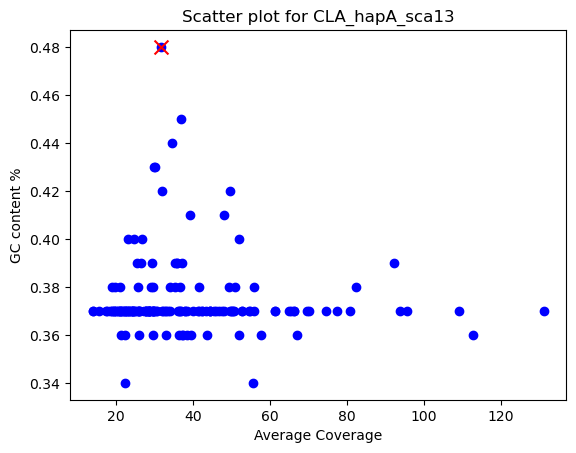

                   id  index  average_coverage  gc_content  Z_coverage  \
83305  CLA_hapA_sca14      0             21.48        0.37   -1.143167   
83306  CLA_hapA_sca14      1             44.33        0.37    0.753809   
83307  CLA_hapA_sca14      2             46.62        0.37    0.943922   
83308  CLA_hapA_sca14      3             57.20        0.37    1.822259   
83309  CLA_hapA_sca14      4             60.66        0.37    2.109504   
...               ...    ...               ...         ...         ...   
83462  CLA_hapA_sca14    157             50.09        0.36    1.231997   
83463  CLA_hapA_sca14    158             43.78        0.36    0.708149   
83464  CLA_hapA_sca14    159             33.97        0.36   -0.106264   
83465  CLA_hapA_sca14    160             23.58        0.36   -0.968828   
83466  CLA_hapA_sca14    161             10.52        0.36   -2.053051   

           Z_gc  
83305  2.933986  
83306  2.933986  
83307  2.933986  
83308  2.933986  
83309  2.933986  
...

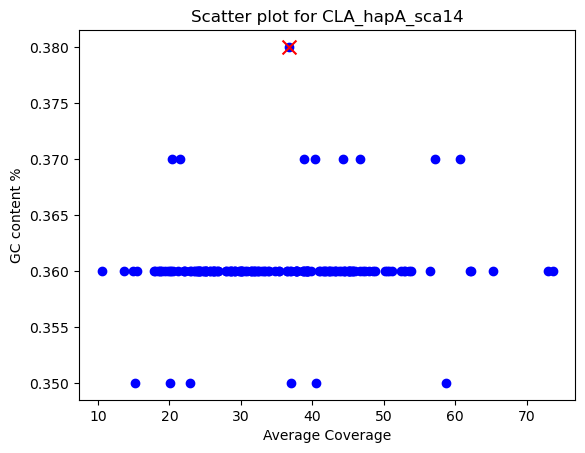

                   id  index  average_coverage  gc_content  Z_coverage  \
83467  CLA_hapA_sca15      0             12.36        0.34   -2.756069   
83468  CLA_hapA_sca15      1             42.31        0.37   -1.538682   
83469  CLA_hapA_sca15      2            100.70        0.38    0.834714   
83470  CLA_hapA_sca15      3             67.37        0.35   -0.520061   
83471  CLA_hapA_sca15      4             59.23        0.36   -0.850930   
...               ...    ...               ...         ...         ...   
83623  CLA_hapA_sca15    156             91.11        0.39    0.444906   
83624  CLA_hapA_sca15    157             80.33        0.39    0.006728   
83625  CLA_hapA_sca15    158             54.52        0.37   -1.042379   
83626  CLA_hapA_sca15    159             37.18        0.34   -1.747203   
83627  CLA_hapA_sca15    160             13.60        0.43   -2.705666   

           Z_gc  
83467 -1.692864  
83468 -0.626823  
83469 -0.271476  
83470 -1.337517  
83471 -0.982170  
...

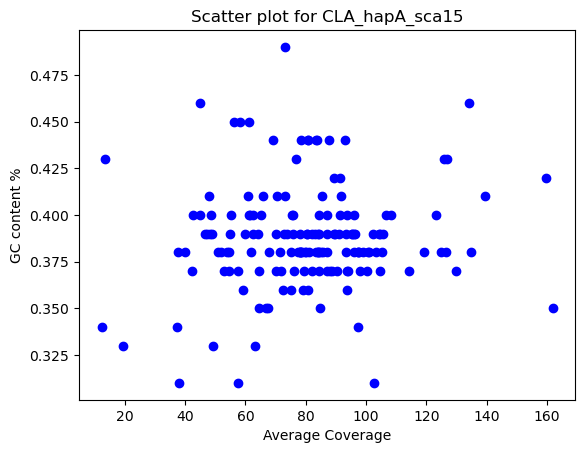

                   id  index  average_coverage  gc_content  Z_coverage  \
83628  CLA_hapA_sca16      0             14.71        0.29   -1.479496   
83629  CLA_hapA_sca16      1             31.66        0.37   -0.764128   
83630  CLA_hapA_sca16      2             45.31        0.33   -0.188036   
83631  CLA_hapA_sca16      3             84.79        0.36    1.478200   
83632  CLA_hapA_sca16      4             60.23        0.32    0.441656   
...               ...    ...               ...         ...         ...   
83780  CLA_hapA_sca16    152             71.13        0.31    0.901686   
83781  CLA_hapA_sca16    153             86.15        0.34    1.535598   
83782  CLA_hapA_sca16    154             47.81        0.35   -0.082525   
83783  CLA_hapA_sca16    155             34.63        0.25   -0.638781   
83784  CLA_hapA_sca16    156              8.52        0.24   -1.740742   

           Z_gc  
83628 -1.891481  
83629  0.682409  
83630 -0.604536  
83631  0.360672  
83632 -0.926272  
...

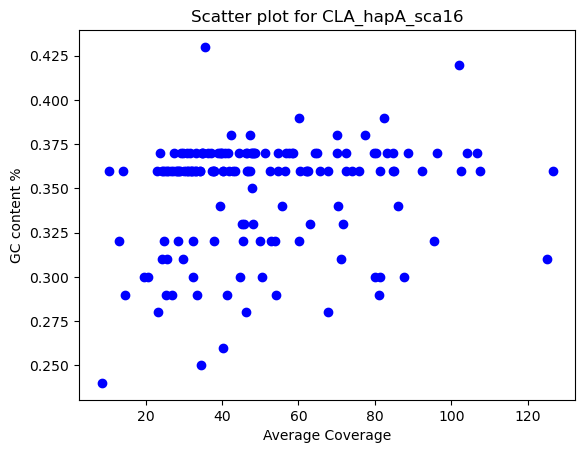

                   id  index  average_coverage  gc_content  Z_coverage  \
83785  CLA_hapA_sca17      0             12.48        0.37   -1.160889   
83786  CLA_hapA_sca17      1             17.44        0.37   -0.989280   
83787  CLA_hapA_sca17      2             19.58        0.37   -0.915239   
83788  CLA_hapA_sca17      3             19.04        0.37   -0.933922   
83789  CLA_hapA_sca17      4             18.05        0.36   -0.968175   
...               ...    ...               ...         ...         ...   
83919  CLA_hapA_sca17    134            131.00        0.36    2.939723   
83920  CLA_hapA_sca17    135             75.26        0.36    1.011204   
83921  CLA_hapA_sca17    136             59.23        0.33    0.456590   
83922  CLA_hapA_sca17    137             54.18        0.30    0.281868   
83923  CLA_hapA_sca17    138             25.70        0.40   -0.703497   

           Z_gc  
83785  0.561217  
83786  0.561217  
83787  0.561217  
83788  0.561217  
83789 -0.569350  
...

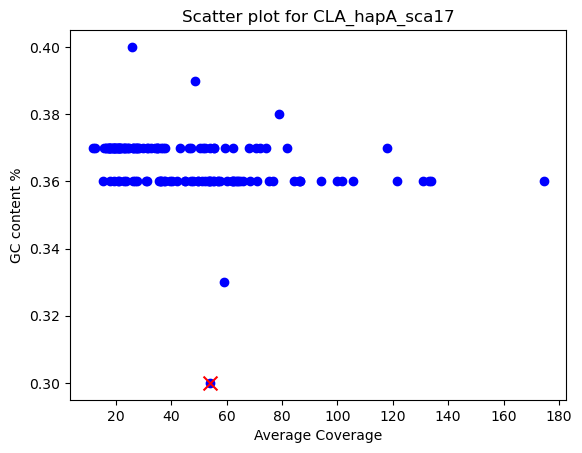

                   id  index  average_coverage  gc_content  Z_coverage  \
83924  CLA_hapA_sca18      0             38.08        0.34   -0.374957   
83925  CLA_hapA_sca18      1             44.15        0.29   -0.206858   
83926  CLA_hapA_sca18      2             43.36        0.30   -0.228736   
83927  CLA_hapA_sca18      3             41.28        0.31   -0.286338   
83928  CLA_hapA_sca18      4             43.82        0.29   -0.215997   
...               ...    ...               ...         ...         ...   
84042  CLA_hapA_sca18    118             48.65        0.36   -0.082238   
84043  CLA_hapA_sca18    119             64.47        0.36    0.355871   
84044  CLA_hapA_sca18    120             48.69        0.36   -0.081130   
84045  CLA_hapA_sca18    121             18.21        0.36   -0.925225   
84046  CLA_hapA_sca18    122             11.21        0.51   -1.119079   

           Z_gc  
83924  0.180191  
83925 -0.783441  
83926 -0.590715  
83927 -0.397988  
83928 -0.783441  
...

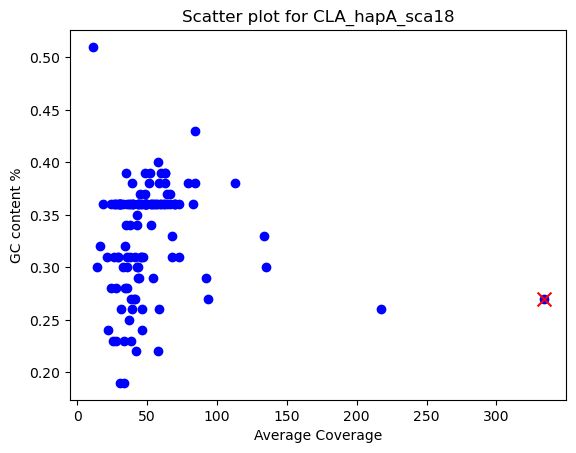

                   id  index  average_coverage  gc_content  Z_coverage  \
84047  CLA_hapA_sca19      0             33.04        0.36   -0.934876   
84048  CLA_hapA_sca19      1             92.48        0.37    0.020628   
84049  CLA_hapA_sca19      2            116.26        0.37    0.402894   
84050  CLA_hapA_sca19      3            219.66        0.37    2.065060   
84051  CLA_hapA_sca19      4            177.37        0.36    1.385244   
...               ...    ...               ...         ...         ...   
84156  CLA_hapA_sca19    109             28.67        0.27   -1.005124   
84157  CLA_hapA_sca19    110             59.70        0.32   -0.506314   
84158  CLA_hapA_sca19    111             76.86        0.35   -0.230465   
84159  CLA_hapA_sca19    112            131.93        0.30    0.654791   
84160  CLA_hapA_sca19    113            127.57        0.38    0.584704   

           Z_gc  
84047 -0.204910  
84048  0.351274  
84049  0.351274  
84050  0.351274  
84051 -0.204910  
...

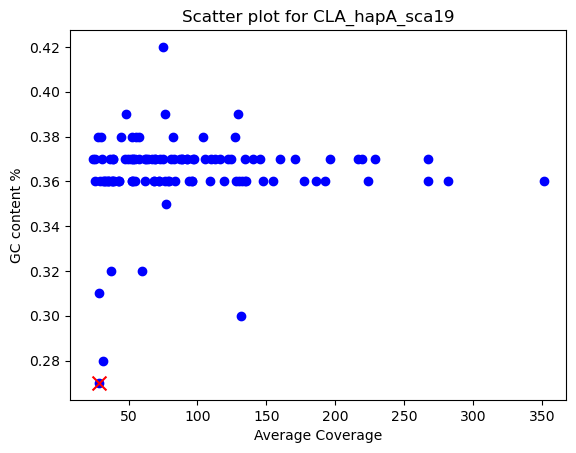

                   id  index  average_coverage  gc_content  Z_coverage  \
84161  CLA_hapA_sca20      0             36.54        0.36   -1.069135   
84162  CLA_hapA_sca20      1             35.36        0.36   -1.094177   
84163  CLA_hapA_sca20      2              6.87        0.36   -1.698791   
84164  CLA_hapA_sca20      3             23.71        0.36   -1.341413   
84165  CLA_hapA_sca20      4             39.25        0.36   -1.011623   
...               ...    ...               ...         ...         ...   
84262  CLA_hapA_sca20    101            194.85        0.37    2.290515   
84263  CLA_hapA_sca20    102            117.17        0.31    0.641993   
84264  CLA_hapA_sca20    103            116.19        0.40    0.621195   
84265  CLA_hapA_sca20    104            118.15        0.34    0.662790   
84266  CLA_hapA_sca20    105             37.99        0.34   -1.038363   

           Z_gc  
84161 -0.798730  
84162 -0.798730  
84163 -0.798730  
84164 -0.798730  
84165 -0.798730  
...

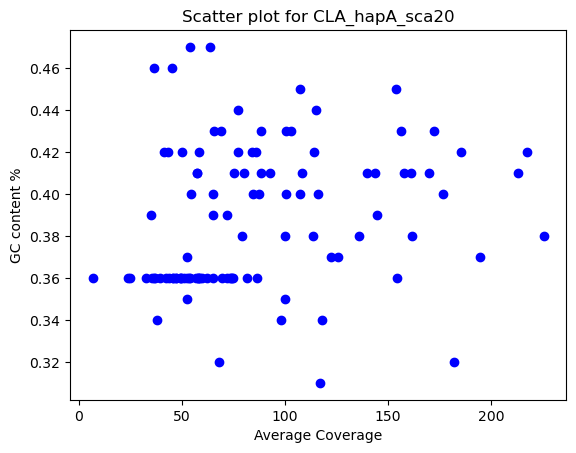

                   id  index  average_coverage  gc_content  Z_coverage  \
84267  CLA_hapA_sca21      0             13.09        0.39   -1.500239   
84268  CLA_hapA_sca21      1             25.97        0.40   -0.840921   
84269  CLA_hapA_sca21      2             27.17        0.38   -0.779494   
84270  CLA_hapA_sca21      3             33.36        0.38   -0.462633   
84271  CLA_hapA_sca21      4             37.39        0.44   -0.256340   
...               ...    ...               ...         ...         ...   
84366  CLA_hapA_sca21     99             53.72        0.37    0.579580   
84367  CLA_hapA_sca21    100             43.96        0.44    0.079973   
84368  CLA_hapA_sca21    101             51.92        0.33    0.487440   
84369  CLA_hapA_sca21    102             46.08        0.36    0.188495   
84370  CLA_hapA_sca21    103             21.11        0.38   -1.089701   

           Z_gc  
84267 -0.010514  
84268  0.353955  
84269 -0.374982  
84270 -0.374982  
84271  1.811828  
...

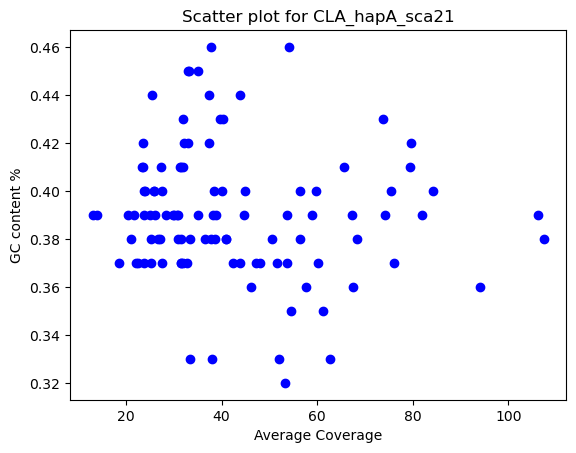

                   id  index  average_coverage  gc_content  Z_coverage  \
84371  CLA_hapA_sca22      0             37.94        0.37   -0.551041   
84372  CLA_hapA_sca22      1             70.28        0.37    0.715237   
84373  CLA_hapA_sca22      2             41.66        0.37   -0.405384   
84374  CLA_hapA_sca22      3             49.25        0.37   -0.108196   
84375  CLA_hapA_sca22      4             63.89        0.37    0.465035   
...               ...    ...               ...         ...         ...   
84470  CLA_hapA_sca22     99             18.22        0.37   -1.323181   
84471  CLA_hapA_sca22    100             21.35        0.37   -1.200625   
84472  CLA_hapA_sca22    101             22.60        0.37   -1.151681   
84473  CLA_hapA_sca22    102             41.25        0.38   -0.421437   
84474  CLA_hapA_sca22    103              6.08        0.37   -1.798524   

           Z_gc  
84371 -0.172345  
84372 -0.172345  
84373 -0.172345  
84374 -0.172345  
84375 -0.172345  
...

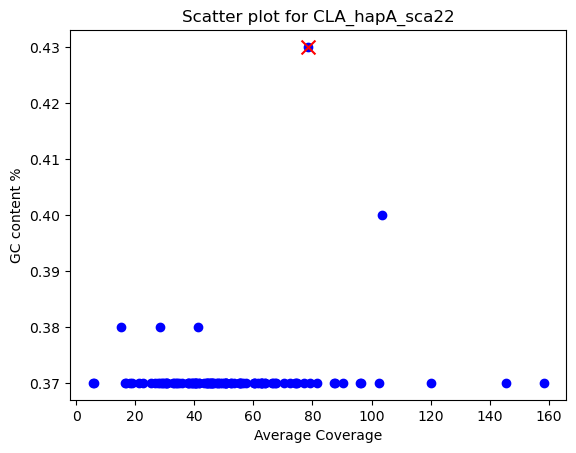

Empty DataFrame
Columns: [id, index, average_coverage, gc_content, Z_coverage, Z_gc]
Index: []


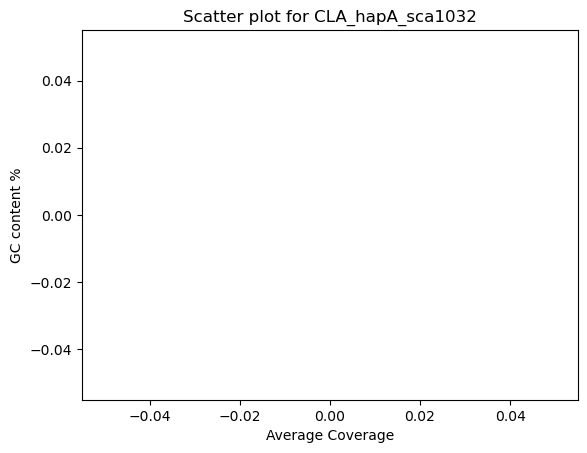

In [77]:
# for each chunk check gc and coverage. color outliers
#add gc content to this
individual = df

def add_gc(row):
    #print(row['id'])
    #print(row['index'])
    #print()
    #print(chunks[row['id']][0][row['index']])
    #print()
    return chunks[row['id']][0][row['index']]
    

individual['gc_content'] = individual.apply(add_gc, axis=1)
print(individual)
# print(len(chunks['CLA_hapA_sca22'][0]))
# print(chunks['CLA_hapA_sca22'][0])


#make a scatterplot
if visualize_contigs:
    for header in chunks:
        
        save_path = os.path.join(individual_output, "individual" + header + ".png")
        # Skip if the plot already exists
        if os.path.exists(save_path):
            print(f'Skipping {id} (already exists)')
            continue
        
        subset_individual = individual[individual['id'] == header]
        # Calculate Z-scores for both columns
        subset_individual['Z_coverage'] = zscore(subset_individual['average_coverage'])
        subset_individual['Z_gc'] = zscore(subset_individual['gc_content'])
        print(subset_individual)
        zscore_threshold = 5.0
        # Mark outliers
        outliers = subset_individual[(abs(subset_individual['Z_coverage']) > zscore_threshold) | (abs(subset_individual['Z_gc']) > zscore_threshold)]
    
        fig, ax = plt.subplots()
        sc = plt.scatter(x = 'average_coverage', y = 'gc_content', data = subset_individual, color = 'blue')
        sc = plt.scatter(x = 'average_coverage', y = 'gc_content', data = outliers, color = 'red', marker='x', s=100)

        # Add labels
        plt.xlabel('Average Coverage')
        plt.ylabel('GC content %')
        plt.title(f'Scatter plot for {header}')
        plt.savefig(save_path)

        plt.show()



# Blob Plot

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


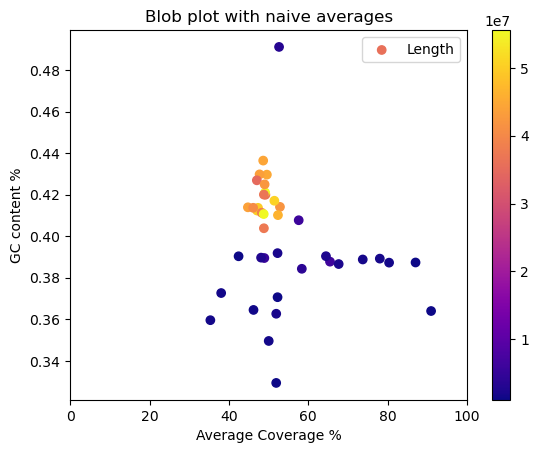

In [14]:
#plot gc content (x) vs coverage (y)
if visualize_blob:

    data = [{'id': k, 'gc_content': v[0]} for k, v in naive_gc.items()]
    data2 = [{'id': k, 'average_coverage': v[0], 'length': v[1]} for k, v in naive_coverage.items()]
    # Convert the list of dictionaries to dataframes
    df1 = pd.DataFrame(data)
    df2 = pd.DataFrame(data2)
    naive_df = pd.merge(df1, df2, on = 'id')
    naive_df = naive_df[naive_df['length'] >= plot_min_length]
    #print(naive_df)

    fig, ax = plt.subplots()
    ax.set_xlim([0, 100])
    cmap = plt.matplotlib.colormaps.get_cmap('plasma')

    sc = plt.scatter(naive_df['average_coverage'], naive_df['gc_content'],  c = naive_df['length'], cmap = cmap)
    cbar = plt.colorbar(sc)
    # Add labels and legend
    plt.xlabel('Average Coverage')
    plt.ylabel('GC content %')
    plt.title('Blob plot with naive averages')
    plt.legend(loc="upper right")
    ax.legend([sc], ['Length'], loc="upper right")
    
    # save the plot
    save_path = os.path.join(out_dir, "Blob_naive.png")
    plt.savefig(save_path)
    plt.show()

else :
    print("Visualize Naive Blob is turned off.")

# Visualize trimmed

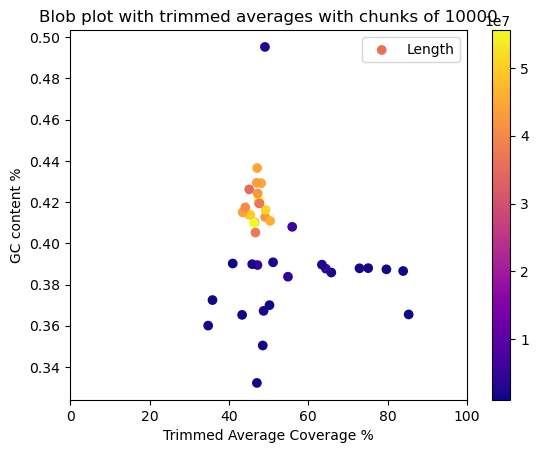

In [15]:
if visualize_blob:

    data = [{'id': k, 'gc_content': v[0], 'length' : v[1]} for k, v in gc_trimmed_mean.items()]
    # Convert the list of dictionaries to dataframes
    df1 = pd.DataFrame(data)
    trimmed_df = pd.merge(df1, trimmed_mean, on = 'id')
    trimmed_df = trimmed_df[trimmed_df['length'] >= plot_min_length]
    #print(trimmed_df) 

    fig, ax = plt.subplots()
    ax.set_xlim([0, 100])
    cmap = plt.matplotlib.colormaps.get_cmap('plasma')

    #labels = list(trimmed_df['id'])
    sc1 = plt.scatter(trimmed_df['average_coverage'], trimmed_df['gc_content'], c = trimmed_df['length'], cmap = cmap)
    cbar = plt.colorbar(sc1)
    # Add labels and legend
    plt.xlabel('Trimmed Average Coverage')
    plt.ylabel('GC content %')
    plt.title('Blob plot with trimmed averages with chunks of ' + str(chunk_size))
    ax.legend([sc1], ['Length'], loc="upper right")

    # save the plot
    save_path = os.path.join(out_dir, "Blob.png")
    plt.savefig(save_path)

else :
    print("Visualize Trimmed Blob is turned off.")

# Histogram of contig lengths

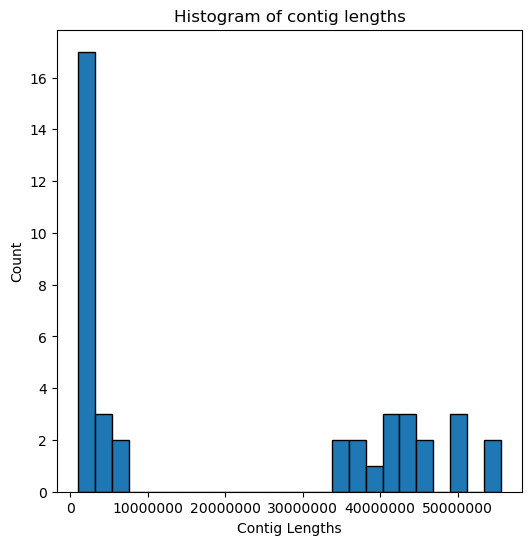

In [20]:
#Histogram of all contig lengths

if visualize_histogram:
    data = trimmed_df["length"]
    #print(data)
    
    fig, ax = plt.subplots(figsize=(6, 6))
    plt.hist(data, bins=25, edgecolor='black')
    ax.ticklabel_format(style='plain', axis='x')
    
    plt.xlabel('Contig Lengths')
    plt.ylabel('Count')
    plt.title('Histogram of contig lengths')
    
    # save the plot
    save_path = os.path.join(out_dir, "Histogram_of_lengths.png")
    plt.savefig(save_path)

    # Show the plot
    plt.show()

In [21]:
print(trimmed_df)

                id  gc_content    length  average_coverage
0        CLA1_hapA    0.419489  35886346             47.68
1        CLA2_hapA    0.405238  37413709             46.66
2        CLA3_hapA    0.412740  41784247             49.12
3        CLA4_hapA    0.413827  49693759             45.36
4        CLA5_hapA    0.429191  44749604             48.12
5        CLA6_hapA    0.416203  50671797             49.23
6        CLA7_hapA    0.410876  46273338             50.36
7        CLA8_hapA    0.413934  49864884             44.97
8        CLA9_hapA    0.429360  43549431             47.00
9       CLA10_hapA    0.410149  38653087             46.42
10      CLA11_hapA    0.421321  55594738             47.48
11      CLA12_hapA    0.419391  36656402             47.61
12      CLA13_hapA    0.415057  43681002             43.44
13      CLA14_hapA    0.426172  34721111             45.10
14      CLA15_hapA    0.424203  42256031             47.22
15      CLA16_hapA    0.409964  55562180             46.

# K-Means

Using this plot you will need to select which cluster is the main cluster for the next step
total length of cluster 0 : 826328052
Cluster 0: aqua star, Cluster 1: green star
total length of cluster 1 : 18226563
Cluster 0: aqua star, Cluster 1: green star


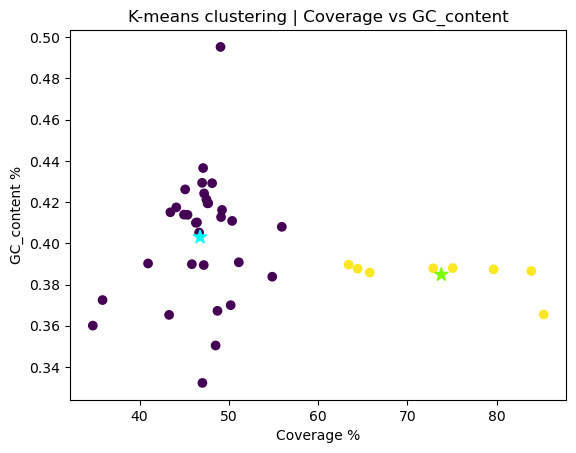

In [17]:
#kmeans to get clusters in blob plots
np.random.seed(42)

coverage = trimmed_df['average_coverage']
gc_content = trimmed_df['gc_content']
ids = trimmed_df['id'].values

#make a feature matrix
X = np.column_stack((coverage, gc_content))

#kmeans clusters = n_clusters
kmeans = KMeans(n_clusters, random_state = 42, n_init='auto').fit(X)
labels = kmeans.labels_
centroids = kmeans.cluster_centers_

#create a dictionary for each cluster
cluster_points = {i: [] for i in range(len(centroids))}

#add the ids to each cluster in the dictionary
for i, label in enumerate(labels):
    cluster_points[label].append(ids[i])
print('Using this plot you will need to select which cluster is the main cluster for the next step')

#look up each point in dataframe to get length
for cluster in cluster_points:
    total_cluster_length = 0
    #for each id for each cluster into a seperate file
    with open(out_dir + 'cluster_info/cluster_' + str(cluster) + '.txt', 'w') as out:
        for i in cluster_points[cluster]:
            #write ids into output
            out.write(i + '\n')
            
            #get length and total length
            length = trimmed_df.loc[trimmed_df['id'] == i, 'length'].iloc[0]
            total_cluster_length += length
    print('total length of cluster ' + str(cluster) + ' : ' + str(total_cluster_length))

    print('Cluster 0: aqua star, Cluster 1: green star')
colors = ['aqua', 'lawngreen']
#plotting
plt.scatter(X[:,0], X[:,1], c = labels)
plt.scatter(centroids[:,0], centroids[:,1], marker = '*', s = 100, c = colors)
plt.xlabel('Coverage')
plt.ylabel('GC_content %')
plt.title('K-means clustering | Coverage vs GC_content')

# save the plot
save_path = os.path.join(out_dir, "Kmeans_clustering.png")
plt.savefig(save_path)

plt.show()

# Making Fasta with ids in target cluster

In [18]:
for n in range(n_clusters):
    #Set target cluster 
    target_cluster = n
    if not os.path.exists(out_dir + 'cluster_info/cluster_' + str(target_cluster)+ '/split_contigs/'):
                os.makedirs(out_dir + 'cluster_info/cluster_' + str(target_cluster)+ '/split_contigs/')

    #for each id in cluster 0 get the sequence and write into a fasta file
        #we already have a fasta file with these ids, we just need to extract only the ones we are interested in
    with open(out_dir + 'cluster_info/cluster_' + str(target_cluster) + '.fasta', 'w') as fasta:
        with open(out_dir + 'cluster_info/cluster_' + str(target_cluster) + '.txt', 'r') as cluster:
            for line in cluster:
                header = line.strip()
                #write header
                fasta.write('>' + header + '\n')
                #before next header write line for sequence
                #search for the header line in assembly which includes header
                with open(assembly, 'r') as big:
                    found = False
                    for line in big:
                        if found:
                            sequence = line.strip()
                            found = False
                            break
                        if header in line:
                            found = True
                big.close()
                fasta.write(str(sequence) + '\n')

        cluster.close()
    fasta.close()

    #Split each entry in fasta file, i.e every 10k take 1k sample
    #for each entry in fasta file, if length > 10000 then take small chunk every 10000bp
    with open(out_dir + 'cluster_info/cluster_' + str(target_cluster) + '.fasta', 'r') as fasta:
        for line in fasta:
            if '>' in line:
                #write in split_contigs
                #print(line)
                line = ''.join(line.split())
                contig_name = str(line.replace('>', ''))
            else:
                with open(out_dir + 'cluster_info/cluster_' + str(target_cluster) + '/split_contigs/' + contig_name + '.fasta', 'w') as contig_file:
                    #split into substrings of len_to_blast every space_to_blast
                    length = len(line)
                    #print(length)
                    if length > (space_to_blast + len_to_blast):
                        #loop
                        pos = 0
                        while pos < length:
                            start = pos
                            end = pos + len_to_blast
                            #header = startpos endpos
                            #sequence = sequence
                            seq = (line[start:end] + '\n')
                            header = ('>' + str(start) + ' : ' + str(end) + '\n')
                            pos += space_to_blast + len_to_blast
                            contig_file.write(header)
                            contig_file.write(seq)

                contig_file.close()

    fasta.close()

Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "/home/afastne/anaconda3/envs/Cladorhizid/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3526, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/tmp/ipykernel_6532/1965066577.py", line -1, in <module>
KeyboardInterrupt

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/afastne/anaconda3/envs/Cladorhizid/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 2120, in showtraceback
    stb = self.InteractiveTB.structured_traceback(
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/afastne/anaconda3/envs/Cladorhizid/lib/python3.11/site-packages/IPython/core/ultratb.py", line 1435, in structured_traceback
    return FormattedTB.structured_traceback(
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/afastne/anaconda3/envs/Cladorhizid/lib/python3.11/site-packages/IPython/core/ultratb.py", line 1326, 

# STOP! Run Blast

# Adjust Cluster 0 and Cluster 1 to where you saved your Blast results

In [ ]:
cluster_0 = './100kb_subset_data/cluster_0/split_contigs/'
cluster_1 = './100kb_subset_data/cluster_1/split_contigs/'
clusters = [cluster_0, cluster_1]
needed = []
needed1 = []
# designate needed to be what you are looking for

#dictionaries
octocoral = ['Dendronephthya gigantea', 'Xenia sp. Carnegie-2017']
dinoflagellates = ['Breviolum minutum Mf 1.05b.01','Symbiodinium microadriaticum','Symbiodinium sp. clade A Y106',
                   'Symbiodinium sp. clade C Y103','Symbiodinium kawagutii','Symbiodinium natans',
                   'Symbiodinium sp. CCMP2592','Symbiodinium sp. KB8','Symbiodinium sp. CCMP2456',
                   'Symbiodinium pilosum','Symbiodinium necroappetens','Cladocopium goreaui']

#for each cluster
for cluster in clusters:
    all_contigs = {}
    concencus_dict = {}
    #for file in each cluster
    for file in os.listdir(cluster):
        filename = file.split('.')[0]
        #count_dict has a count of number of each occurence of match
        count_dict = {'Breviolum minutum Mf 1.05b.01':0,'Symbiodinium microadriaticum':0,
                      'Symbiodinium sp. clade A Y106':0,'Symbiodinium sp. clade C Y103':0,'Symbiodinium kawagutii':0,
                      'Symbiodinium natans':0,'Symbiodinium sp. CCMP2592':0,'Symbiodinium sp. KB8':0,
                      'Symbiodinium sp. CCMP2456':0,'Symbiodinium pilosum':0,'Symbiodinium necroappetens':0,
                      'Cladocopium goreaui':0,'Dendronephthya gigantea':0, 'Xenia sp. Carnegie-2017': 0}
        if '.long.tab' in file:
            with open(cluster + file, 'r') as f:
                #print(filename)
                #get header number, get last column
                for line in f:
                    line = line.split(sep = '\t')
                    #increase count for match
                    for entry in count_dict:
                        if entry in line[24].strip('\n'):
                            count_dict[entry]+=1
            all_contigs[filename] = count_dict
            
    #get count of octocorral and dinoflagellates
    for p in all_contigs:
        o = 0
        d = 0
        for entry in all_contigs[p]:
            #print(entry)
            if entry in dinoflagellates:
                d+=all_contigs[p][entry]
            if entry in octocoral:
                o+=all_contigs[p][entry]
        
        #decide (octocoral/dinoflagellates/mixed/none)
        decision = 'none'
        if d == 0 and o >= 1:
            decision = 'octocoral'
        if d >= 1 and o ==0 :
            decision = 'dinoflagellates'
        if d >= 1 and o >= 1:
            if (d/o) < threshold:
                decision = 'octo'
            else:
                decision = 'mixed'
        #add decision to concensus dict
        concencus_dict[p] = decision     
    
    #print totals of each
    octo=dino=mixed=none=0
    for key in concencus_dict:
        if concencus_dict[key] in 'octocoral':
            octo +=1
#!!!!!!!!!!!!!!!!Change this to where you want it, if you have other data replace the dicts above too!!!!!!!!!!!!
            if n == 0:
                needed.append(key)
            else:
                needed1.append(key)
        if concencus_dict[key] in 'dinoflagellates':
            dino +=1
        if concencus_dict[key] in 'mixed':
            mixed +=1
        if concencus_dict[key] in 'none':
            none +=1
#     print('octo: ' + str(octo))
#     print('dino: ' + str(dino))
#     print('mixed: ' + str(mixed))
#     print('none: ' + str(none))

In [ ]:
#write to output file
with open('./out_dir/cluster_info/needed.txt','w') as out:
    for i in needed:
        out.write(str(i) + '\n')
out.close()
print('length in needed.txt: ', len(needed))
with open('./out_dir/cluster_info/needed1.txt','w') as out:
    for i in needed1:
        out.write(str(i) + '\n')
out.close()
print('length in needed.txt: ', len(needed1))

# Blob Plot with Fasta

In [ ]:
#trimmed_df['id'] = int(trimmed_df['id'])
with open('out_dir/cluster_info/needed1.txt','r') as keys:
    tot = []
    for line in keys:
        k = line.strip('\n')
        tot.append(k)
print('total length: ', len(tot))
     
#plot blob again and color contigs with keys as labels

data = [{'id': k, 'gc_content': v[0], 'length' : v[1]} for k, v in gc_trimmed_mean.items()]
# Convert the list of dictionaries to dataframes
df1 = pd.DataFrame(data)
trimmed_df = pd.merge(df1, trimmed_mean, on = 'id')
trimmed_df = trimmed_df[trimmed_df['length'] >= plot_min_length]
#print(trimmed_df) 

#add column if contained in keys
trimmed_df['in_fasta'] = trimmed_df['id'].isin(tot)
#print(trimmed_df)
print('Contigs found in this set also in Blast' + str(trimmed_df.in_fasta.sum()))

fig, ax = plt.subplots()
ax.set_xlim([0, 100])

#labels = list(trimmed_df['id'])
sc1 = plt.scatter(trimmed_df['average_coverage'], trimmed_df['gc_content'], c = trimmed_df['in_fasta'])
cbar = plt.colorbar(sc1)
# Add labels and legend
plt.xlabel('Trimmed Average Coverage %')
plt.ylabel('GC content %')
plt.title('Blob plot with trimmed averages with chunks of ' + str(chunk_size))
ax.legend([sc1], ['in_fasta'], loc="upper right")

# save the plot
save_path = os.path.join(out_dir, "Fasta_Blob.png")
plt.savefig(save_path)

# Show the plot
plt.show()

## Plot histogram of lengths of this subset

In [ ]:
#Bar plot of lengths of in fasta in trimmed_df
data = trimmed_df[trimmed_df["in_fasta"] == True]
data = data.sort_values(by=['length'], ascending=False)
#x is ids
x = data['id']
#y is length of ids
y = data['length']

#color contigs up to total length of genome size
current = 0
length = genome_size
#add lengths together till greater than length
for i, l in enumerate(y):
    current += l
    if current > length:
        #print(i)
        cutoff = l
        break
        
mask1 = y >= cutoff
mask2 = y < cutoff

plt.bar(x[mask1], y[mask1], color = 'red')
plt.bar(x[mask2], y[mask2], color = 'blue')
#plt.bar(x, y)

plt.xlabel('Contig ids')
plt.ylabel('Lengths')
plt.title('Bar plot of contig lengths in Blast results')
# save the plot
save_path = os.path.join(out_dir, "Histogram_of_lengths_of_subset.png")
plt.savefig(save_path)

# Show the plot
plt.show()

# Manually inspect and set cutoffs

In [ ]:
#save selected contigs
results_cutoff = 190
subset = data.head(results_cutoff)
#print(subset)
subset.to_csv('./out_dir/blast_subset.csv',index=False)

In [ ]:
#for each id in blast_subset add that contig to a fasta file
ids = []
with open('./out_dir/blast_subset.csv','r') as csv_file:
    reader = csv.reader(csv_file)
    next(reader)
    for row in reader:
        ids.append(row[0])
    
output_file = open('./data/ourGenome.fasta', 'a')
with open(assembly, 'r') as fasta_file:
    header = ''
    sequence = ''
    for line in fasta_file:
        if line.startswith('>'):
            #check if id in list
            if any(id in line for id in ids):
                header = line.strip()
        else:
            sequence = line.strip()
            if header and sequence:
                output_file.write(header + '\n')
                output_file.write(sequence + '\n')
                header = ''
                sequence = ''
                
output_file.close()

In [ ]:
#TODO find lengths of discarded
data = [{'id': k, 'gc_content': v[0], 'length' : v[1]} for k, v in gc_trimmed_mean.items()]
# Convert the list of dictionaries to dataframes
df1 = pd.DataFrame(data)
discarded = pd.merge(df1, trimmed_mean, on = 'id')
discarded = discarded[discarded['length'] >= plot_min_length]
discarded['in_fasta'] = discarded['id'].isin(tot)
#print(discarded)

#take only false
data = discarded[discarded["in_fasta"] == False]
data = data.sort_values(by=['length'], ascending=False)
#print(data)

#x is ids
x = data['id']
#y is length of ids
y = data['length']
plt.bar(x,y)

plt.xlabel('Contig ids')
plt.ylabel('Lengths')
plt.title('Bar plot of contig lengths NOT in Blast results')
save_path = os.path.join(out_dir, "Histogram_of_lengths_not_in_Blast_results.png")
plt.savefig(save_path)

# Show the plot
plt.show()

# Now go on to use the Filtered Results :)